<a href="https://colab.research.google.com/github/Ujustwaite/ml1/blob/master/Lab_2_Waite_Garapati_Henderson_Walenciak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 2: Classification Using New York City Fire Department Data:**


### Team: Aditya Garapati, Chase Henderson, Brian Waite, Carl Walenciak

### Date: 10/27/2019




# General Description:

## Business Understanding:

This is a continuation of the analysis of the Fire Department of New York City (FDNY) data describing fire incidents in support of the New York Fire Incident Reporting System (NYFIRS). Prior to and during our initial data preparation, we identified a number of analytic questions that could be of interest to fire resource planners. 

New York City uses a series of alarm codes to identify the severity of a fire and the associated response. These alarm codes are described at the following web locations: 

http://www.fdnewyork.com/aa.asp

https://en.wikipedia.org/wiki/New_York_City_Fire_Department#Radio_and_bell_code_signals


## Problem Statement 1: Predicting High-Alarm vs. Low-Alarm Fires



Build a classification model that can **predict whether a fire constitutes a severe, high level incident, or a less-severe fire** based on parameters contained in the available data set. 

By building this classification model, we seek not only to identify the level of incidents based on parameters, but also to identify factors that contribute to an incident being classified as a high-level / low-level incident in order to aid planners in their future decision making process. 

#### Problem 1 Approach: 

This analysis builds upon the work previously submitted in the Mini-Lab assignment. In additon to using logistic regression and support vector machine models, we expand our analysis to include a Random Forest Classifier. With each we provide appropriate interpretation of the model parameters to understand the factors that contribute to the classification decision. 

For those models (Logistic Regression and SVM) that were used in the Mini-Lab, we will carry forward the optimization that we performed to gain best performance. This is typically the model with the best performance after performing a GridSearch on a variety of model parameters. Those "best fit" model parameters will be carried forward and run once here. 

For models not previously included in other assignments, the full GridSearch / optimization process is displayed and model performance evaluation according to selected criteria is described. 

## Problem Statement 2: Predicting Total Incident Duration of Fire Events


The second problem was not a part of the mini-lab assignment and expands our analysis to include the new **prediction of the `total incident duration` value.** Based on the features given, we seek to provide a model for predicting how long an incident might last given the parameters. This can possibly help immediate decision making about how to balance resources and the ability for fire department leadership to shorten the length of incidents by adjusting future responses.

#### Problem 2 Approach: 

In our analysis below, we will employ a number of linear regression models built using a variety of features and parameters in an attempt to identify the best possible model providing the most reliable predictions. Feature selection , interaction terms, and other techniques will be applied to both maximize the model and align as closely to the assumptions required for linear regression as possible. 

In addition to the multiple linear regression techniques, we explore the use of a Random Forest based regressor that is capable of leveraging random forest techniques like those we studied in the classification portion of the course with linear regression techniques. 

# Data Preparation: 

## Data Description: 

A robust description of the data has been previously provided along with an associated Exploratory Data Analysis. That information is available here for reference: https://colab.research.google.com/github/Ujustwaite/ml1/blob/master/Playing_With_Fire.ipynb

## Data Cleaning: 

To optimize this analysis, we need to do some additional transformation of the data and some leftover housekeeping from our EDA. This includes: 

* Conversion of the presence of the Automatic Extinguisher System to either "not present = 0" or "present = 1". 

* Conversion of the presence of a fire dector to either "not present = 0" or "present = 1". 

* Conversion of the presence of a standpipe system to "not present = 0" or "present = 1". 

* Filling of missing `total_incident_duration` values with the mean value. **Note that this process has been updated to take place after the separation of the Train / Test data in order to not pollute the model with advance knowledge of the Test data set.**

* Correction of two incorrect zip code values. 

* Dropping of categorical fields that are freely input by the user and are unusable for analysis or are not consistently used in a meaningful sense for this problem. 

In [0]:
!pip install category_encoders

In [0]:
#Imports Section
import category_encoders as ce
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [0]:
#Read in the data output from EDA step
final_df = pd.read_pickle('final_df.pkl')

In [0]:
#DATA CLEANING BLOCK

#AES presence update
final_df.loc[final_df['aes_presence_desc'] == '1 - Present', 'aes_presence_desc'] = 1
final_df.loc[final_df['aes_presence_desc'] != 1, 'aes_presence_desc'] = 0

#Smoke Detector presence update
final_df.loc[final_df['detector_presence_desc'] == '1 - Present', 'detector_presence_desc'] = 1
final_df.loc[final_df['detector_presence_desc'] != 1, 'detector_presence_desc'] = 0

#Standpipe presence update
final_df.loc[final_df['standpipe_sys_present_flag'] == '1', 'standpipe_sys_present_flag'] = 1
final_df.loc[final_df['standpipe_sys_present_flag'] != 1, 'standpipe_sys_present_flag'] = 0

#Replacement of missing zip codes
#Identified values using google maps and intersection information
final_df.at[18695, 'zip_code'] = '11103'
final_df.at[18760, 'zip_code'] = '11357'

#Drop the categorical columns determined to be unusable
final_df = final_df.drop(columns = ['fire_spread_desc','floor','story_fire_origin_count'])

#Drop the remaining 19 values that are missing the highest level alarm description
final_df.dropna(inplace = True)

### Problem 1 Data Preparation:  Define and prepare your class variables.

Because the target variable is not currently in the data set, we must construct it with the existing available data set. 

Here we will take the existing feature, `highest_level_desc` that defines the level of alarm raised for each incident in the data set and convert it to a binary value. The values contained in the data set are: 

In [0]:
final_df.highest_level_desc.unique()

array(['11 - First Alarm', '75 - All Hands Working',
       '1 - More than initial alarm, less than Signal 7-5',
       '7 - Signal 7-5', '2 - 2nd alarm', '0 - Initial alarm',
       '22 - Second Alarm', '5 - 5th alarm', '4 - 4th alarm',
       '3 - 3rd alarm', '55 - Fifth Alarm', '33 - Third Alarm',
       '44 - Fourth Alarm'], dtype=object)

As you might expect, the majority of the events occuring throughout the city are low-level fires.

In [0]:
grouped = final_df.groupby(['highest_level_desc'])
grouped.count().im_incident_key

highest_level_desc
0 - Initial alarm                                       19
1 - More than initial alarm, less than Signal 7-5    12963
11 - First Alarm                                     11873
2 - 2nd alarm                                           53
22 - Second Alarm                                       47
3 - 3rd alarm                                           13
33 - Third Alarm                                        11
4 - 4th alarm                                            4
44 - Fourth Alarm                                        5
5 - 5th alarm                                            5
55 - Fifth Alarm                                         5
7 - Signal 7-5                                         701
75 - All Hands Working                                 621
Name: im_incident_key, dtype: int64

This means we have the potential for the data of "in class" vs. "out of class" to be highly imbalanced. We'll address this later in our analysis. For our analysis, we determined based on the definitions of the alarms in the references provided and on our initial EDA, that a severe fire is level 2 including Signal 7 / Signal 75, which are not truly 2 alarm or higher, but help to balance the in class data set. 

In [0]:
#Split the alarm code off the front of the description
new = final_df["highest_level_desc"].str.split(" ", n = 1, expand = True) 
#Convert to integer
new[0] = new[0].astype('int32')
#Map the classifications according to alarm code
desc = {2: 1,22: 1, 3:1,33:1,4:1,44:1,5:1,55:1,0:0,1:0,11:0,7:1,75:1,} 
final_df['FireLevel'] = [desc[item] for item in new[0]] 

In [0]:
#Number of in class records
final_df.FireLevel.sum()

1465

In [0]:
#Total number of records
final_df.FireLevel.shape[0]

26320

Our target variable is now contained in the data frame as `FireLevel`. As we can see, there are 1,467 in class values out of the total 26,322 records. Approximately 5.6 percent. We will monitor and adjust for this imbalance throughout our analysis. 

## Encoding of Categorical Predictors

In order to ensure the categorical values are providing balanced contributions to the model, we leverage one-hot encoding. This significantly increases the number of features. 

In [0]:
#Encode borough description
label = ce.OneHotEncoder(use_cat_names=True)
borough_label = label.fit_transform(final_df[['borough_desc']])

#Encode incident type
label = ce.OneHotEncoder(use_cat_names=True)
incident_type_label = label.fit_transform(final_df[['incident_type_desc']])

#Encode actiontaken 1 label -- the primary action taken by units onscene
label = ce.OneHotEncoder(use_cat_names=True)
action_taken_1_label = label.fit_transform(final_df[['action_taken1_desc']])

#Encode highest level desc for Problem 2
label = ce.OneHotEncoder(use_cat_names=True)
highest_level_label = label.fit_transform(final_df[['highest_level_desc']])

## Drop Columns Not to be Used in Analysis

### Problem 1 drops

A number of the columns in the dataframe are now duplicative of the encoded columns or are redundant / not useful. Things like zip_code, street_highway, and nearest_intersection are already captured in lat/long that we'll retain. We have translated Date Time related information into the Total Incident Duration and will not use that here. 

In [0]:
#drop the unnecessary columns
model_df = final_df.drop(columns = ['action_taken1_desc', 'action_taken2_desc', 'action_taken3_desc', 'borough_desc','fire_box', 'highest_level_desc', 'im_incident_key', 'incident_date_time', 'incident_type_desc', 'last_unit_cleared_date_time', 'property_use_desc', 'street_highway', 'zip_code', 'nearest_intersection','incident_code', 'incident_desc', 'DATE'])

In [0]:
#concatenate the encoded columns
model_df = pd.concat([model_df,incident_type_label, action_taken_1_label, borough_label], axis = 1)

In [0]:
#Move the target value to the end of the dataframe and rename as target
model_df['target'] = model_df['FireLevel']
model_df = model_df.drop(columns = 'FireLevel')

Also during the Mini-Lab assignment, we identified that the `units_onscene` and `total_incident_duration` were essentially representing the same value as our "to be predicted" target variable. They were therefore skewing the model to be accurate when in fact it was not really "predicting" anything, and so we made the determination to leave them out of the Problem 1 analysis. 

In [0]:
#Drop columns that violate the independence assumption. 
model_df = model_df.drop(columns = ['total_incident_duration', 'units_onscene'])

## Create Train / Test Split

In order to prepare for the analysis, we will use a shuffled 80/20 Train-Test split with stratification due to the small number of representative samples of the "in class" variables described above. The data is randomly selected for inclusion in either split, with a set seed to enable replication of results, but is stratified to ensure representation in both the train and test sets of the in class records. 

In [0]:
#Problem 1 data
X_p1_train, X_p1_test, y_p1_train, y_p1_test = train_test_split(model_df.iloc[:,0:97], model_df.iloc[:,97], test_size=0.20, random_state=42, shuffle = True, stratify = model_df.iloc[:,97])


### Scaling

Also, to properly evaluate the relative importance of features in some of the models, we create a scaled version of the data. This is particularly useful when comparing the feature importance in the logistic regression and to properly execute the svm. Scales are built on the training data and applied to the test data in order to maintain the same relative importance / values. 

In [0]:
#Recreate the scaled data set with dropped variables. 

scl_obj = StandardScaler()
scl_obj.fit(X_p1_train) 

X_p1_train_scaled = scl_obj.transform(X_p1_train) # apply to training
X_p1_test_scaled = scl_obj.transform(X_p1_test) # applyto the test set

### Upsampling to obtain balanced records

To address the large imbalance in the data set, we successfully implemented code to up-sample the "in-class" records in the data set to be equally present in the data set with "out of class" records. 

In [0]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_p1_train, y_p1_train], axis=1)

# separate minority and majority classes
not_severe = X[X.target==0]
severe = X[X.target==1]

# upsample minority
severe_upsampled = resample(severe, replace=True, # sample with replacement
                          n_samples=len(not_severe), # match number in majority class
                          random_state=123) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_severe, severe_upsampled])

# check new class counts
upsampled.target.value_counts()

1    19884
0    19884
Name: target, dtype: int64

This same process can be used by using the class_weight = 'balanced' flag when creating the model objects, but we wanted to execute the up-sampling to understand the process for doing so. 

Reference: https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

### Describe the final dataset that is used for classification/regression.

Recall that during the initial phases of our research, we identified the need for a number of engineered features. These remain included in the data set and are as follows: 



*   `Distance_To_Nearest_Station`: An engineered feature derived by measuring the distance between the nearest firehouse location and the firebox. Straight line distance using Mercator projection.	
*   `response_time`:	An engineered feature derived from arrival time of first units on scene and the time the incident occured.

Note also that we expanded the data set with location information about the fire boxes and weather related information for NYC on the date of the incident.

*   `LONG`	Longitude of the firebox location where the incident occured.
*   `LAT`  	Latitude of the firebox location where the incident occured.
*   `PRCP`:	Precipitation amount as measured in Central Park on date of the incident.
*   `SNOW`	Amount of precipitation that was recorded as snowfall.
*   `SNWD`	Amount of snow accumulation reported on the day of the incident.

The final data set has the following parameters: 

In [0]:
#Number of features
X_p1_train.shape

#(Number of Records, Number of Features w/One Hot Encoding)

(21056, 97)

In [0]:
#Number of in-class in train data
y_p1_train.sum()

1172

In [0]:
#Number of records in test set
X_p1_test.shape

(5264, 97)

In [0]:
#Number of in-class in test set
y_p1_test.sum()

293

# Modeling and Evaluation

## Evaluation Metrics and Reasoning: 

#### Problem 1: Classification of Fire Severity

Evaluation of classification models will be through the use of confusion matrix based statistics including accuracy, precision and recall. Because of the small occurrence rate of high severity fires, we found accuracy to be an unreliable indicator of the performance of our model in and of itself. Therefore, we prefer models that balance the performance across these multiple indicators. 

In addition, the Area Under the Curve (AUC) assessments using Receiver Operating Characteristic (ROC) curve analysis is used to compare model performance and to evaluate the performance of any final selected model.

For our Random Forest model, we can also explore the probability with which the model predicted the values and the distribution to evaluate the performance. 


#### Problem 2: Prediction of Total Incident Duration

In order to evaluate our regression models, we will leverage some of the statistical evaluation techniques. This will include comparison plots of the expected vs. predicted values, residual plots to determine if we can meet the assumptions of linear regression modeling, and metrics such as the R-squared value to compare various iterations of our models for performance. 

## Splitting Procedure for Data

For both problems, we are splitting the data in an 80/20 split with shuffled assignment and stratification to preserve the proportion of in-class / out-of-class values in both the train / test sets. When running the Grid Search on the models to optimize parameters, we use 3-fold cross validation. 

We understand that 3-fold cross validation is less preferable than 5 or 10 fold that are more standard. However, due to the computing resources available, time constraints the team is operating under, the number of model types being run, and the need to meet a specific deadline, 3-fold cv was selected in order to demonstrate the improvement gained, while still producing results in a reasonable time. 

Stratification is required due to the small number of in-class exemplars, particularly for Problem 1. The initial shuffling ensures semi-random assignment (with stratification exception) to train / test sets and the in model use of cross validation ensures an optimized representation of the data. 

## Problem 1: Classification Modeling and Analysis

In building a predictive classifier to determine whether a fire is "severe" or "not severe", we used both logistic regression and a support vector machine model in the Mini-Lab. This analysis builds on the work that was done there to expand to additional models and to further evaluate the factors that contribute to a fire's severity and the implied business insights that can be gained. 

The logistic regression and support vector models shown below are the result of optimization processes that used Grid Search methods that are documented in the Mini-lab assignment. The final models are displayed. 

### Logistic Regression: 

Leveraging our previous mini-lab work, we can fit a logistic regression model with our previously identified optimal parameters. 

In [0]:
#Fit the model using the final selected parameters. 
lr_clf = LogisticRegression(fit_intercept = True, intercept_scaling = 1, solver = 'newton-cg', max_iter = 500, penalty='l2', C=0.001, tol = 0.0001, class_weight='balanced')
lr_clf.fit(X_p1_train_scaled,y_p1_train)  # train object
y_hat = lr_clf.predict(X_p1_test_scaled)

In [0]:
# print the accuracy and confusion matrix 
print("accuracy", mt.accuracy_score(y_p1_test,y_hat)) 
print("precision", mt.precision_score(y_p1_test,y_hat))
print("recall", mt.recall_score(y_p1_test,y_hat))
print("confusion matrix\n",mt.confusion_matrix(y_p1_test,y_hat))


accuracy 0.9517477203647416
precision 0.5383104125736738
recall 0.9351535836177475
confusion matrix
 [[4736  235]
 [  19  274]]


Our accuracy and recall both perform well, but our model suffers a bit in the area of precision. Accuracy is likely over-inflated due to the imbalance in the data set even though we have sought to compensate for this by upsampling the positive class. If precision is an indication of the probability of the model to predict correct values, then we may need to continue to seek improvement here. This could mean we need to seek additional data or additional features within the data we have to continue to improve. 

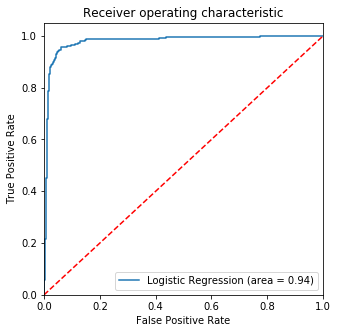

In [0]:
# Produce a ROC curve
matplotlib.rcParams['figure.figsize'] = (5.0, 5.0)
logit_roc_auc = mt.roc_auc_score(y_p1_test, lr_clf.predict(X_p1_test_scaled))
fpr, tpr, thresholds = mt.roc_curve(y_p1_test, lr_clf.predict_proba(X_p1_test_scaled)[:,1])
#logit_auc = mt.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The above ROC curve demonstrates a strong model with an AUC of 0.94. 

## Interpreting the Logistic Regression Model: Variable Importance

One of the benefits of the logistic regression model is its ease of interpretation. Once we scaled the data being entered into the model, we are able to compare the values against each other and identify contributing factors to whether a fire is more or less severe. 

**Building and structure fires are the most severe.**

The greatest contributor to whether a fire is classified as severe or not is whether the incident type is reported as a building fire. In addition, fires in a structure other than a building is has high relative influence. Counterintuitively, the presence of a smoke detector is correlated with a more severe fire in the model, but this is likely due to the fact that detectors are primarily placed inside of structures -- which as we see are at greatest risk.

**Contained fires, cooking fires in their original container, outdoor fires, or vehicle fires are generall not severe.**

Cooking fires in their container, outdoor rubbish or garbage fires, and vehicle fires are the strongest contributors to a fire being classified as not severe. This makes sense as their contained or isolated nature would make them less likely to spread and become a more dynamic fire.

**Geographic boroughs within the city do have an impact on fire severity.**

Fires occuring in Staten Island have the greatest risk of being classified as severe with Queens also being at significant risk. Conversely, Manhattan and the Bronx are more correlated with less severe fires. Being located in Brooklyn appears neutral.

This differentiation could be the result of fire department density in those areas or the types of structures present in either. Queens and Staten Island are more likely to have residential structures that may not be equipped with sprinkler systems or robust alarms. It might be worthwhile evaluating interaction terms between location and some of these other attributes in further modeling attempts.

LATITUDE and LONGITUDE also contributed to the model in a manner generally consistent with this. Increased LATITUDE (or more Northern boroughs) were generally at less risk (Manhattan and the Bronx are the Northernmost boroughs). It makes sense that LONGITUDE's contribution is less because many of the boroughs share the same relative longitude.

Increased distance to the nearest fire station also has some measurable contribution to increasing whether a fire will be classified as severe. Greater distance is a greater risk of severity and is likely an indication of the amount of time the fire has to develop.

**Action taken may be more informative about future resource allocation**

The action taken category is likely not a strong predictor, but does offer insight into how resources are used in both severe and non-severe fires. Not surprisingly, during severe fires the action taken was highly correlated with extinguishing actions, establishment of control centers, and deployment of hoses in support of a precautionary effort.

On the other hand, actions involved in non-severe fires included investigations, securing of the surrounding area, or finding the fire "out on arrival". Additional trend analysis on this data may offer some insight as to the level of unit that may need to be incorporated into the force or the training areas that teams need to focus on.

**Increased precipitation is associated with less severe fires.**

Although it may seem obvious, the model confirms the fact that both rain precipiation and snow are associated with decreased fire severity. Interestingly, increased snow depth (SNWD in our model) indicating actually accumulated snow is a relatively strong indicator of decreased fire severity. Perhaps this is due to the ability of melting snow to aid in putting out fires.

In [0]:
# Sort the features by weight and display
zip_vars = zip(lr_clf.coef_.T,X_p1_test.columns) 
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has scaled weight of', coef[0]) 

incident_type_desc_113 - Cooking fire, confined to container has scaled weight of -0.6078372888188093
incident_type_desc_151 - Outside rubbish, trash or waste fire has scaled weight of -0.2011376663503909
incident_type_desc_131 - Passenger vehicle fire has scaled weight of -0.15426890529043993
response_time has scaled weight of -0.14902876998945447
action_taken1_desc_21 - Search has scaled weight of -0.13078199175422262
action_taken1_desc_53 - Evacuate area has scaled weight of -0.1220532390172842
action_taken1_desc_86 - Investigate has scaled weight of -0.10059047366813614
action_taken1_desc_215 - Check for extension has scaled weight of -0.08214431283431704
LAT has scaled weight of -0.08134114890222817
borough_desc_1 - Manhattan has scaled weight of -0.07850818391078114
action_taken1_desc_87 - Investigate fire out on arrival has scaled weight of -0.06874468622743989
incident_type_desc_132 - Road freight or transport vehicle fire has scaled weight of -0.054742147026858666
PRCP has sca

Both the coefficients and the feature importance plot below demonstrate the findings we describe above. We can see that Building Fire stands out above the rest and Cooking Fires that remain confined to the container they originate in often are less severe. 

Text(0.5, 1.0, 'Feature importance')

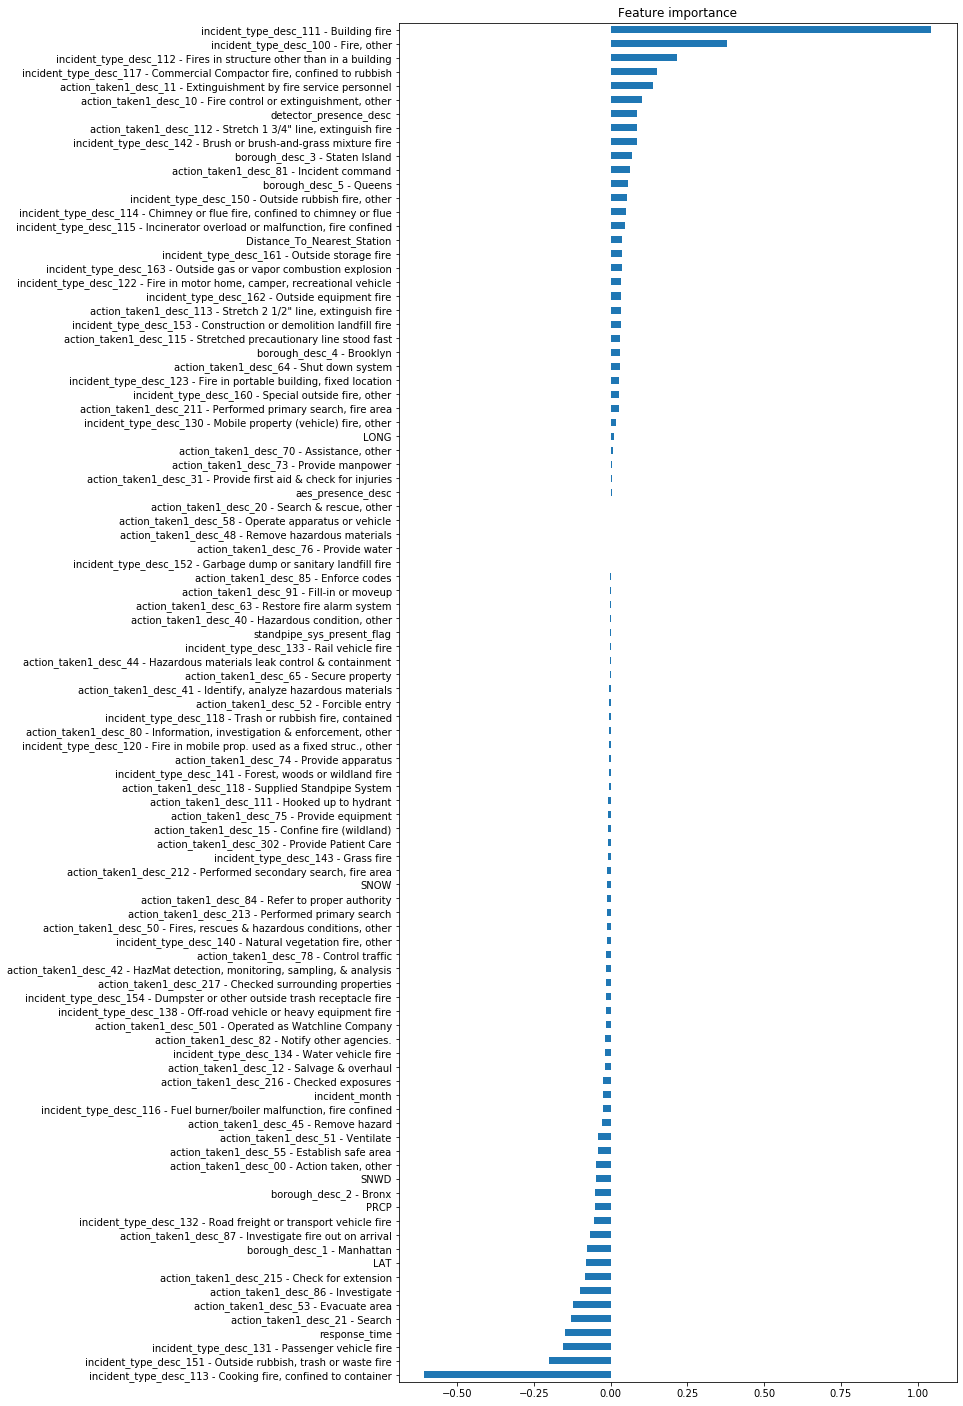

In [0]:
# Examine the feature importance by using the coefficients of the LR model. 
coef = pd.Series(lr_clf.coef_[0], index = X_p1_train.columns)
# Sort the coefficients for easy interpretation
imp_coef = coef.sort_values()
# Expand the plot to display nicely. 
matplotlib.rcParams['figure.figsize'] = (10.0, 25.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance")

### Support Vector Machine

This SVM model again draws on the previous work from the mini-lab. The parameters are the result of a Grid Search and represent the most balanced model that we were able to obtain.

In [0]:
#Fit SVM with the optimized parameters
svm_clf = SVC(C=0.001, cache_size=200, class_weight='balanced',
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.01, kernel='sigmoid', max_iter=-1,
                     random_state=None, shrinking=True,
                     tol=0.001, verbose=False, probability = True)
# fit using the scaled data set
svm_clf.fit(X_p1_train_scaled, y_p1_train)

y_hat_svm = svm_clf.predict(X_p1_test_scaled)

In [0]:
print("accuracy", mt.accuracy_score(y_p1_test,y_hat_svm)) 
print("precision", mt.precision_score(y_p1_test,y_hat_svm))
print("recall", mt.recall_score(y_p1_test,y_hat_svm))
print("confusion matrix\n",mt.confusion_matrix(y_p1_test,y_hat_svm))

accuracy 0.9741641337386018
precision 0.7315634218289085
recall 0.8464163822525598
confusion matrix
 [[4880   91]
 [  45  248]]


Here our precision metric is significantly improved, while the recall value takes a slight hit when compared to the logistic regression model above. That said, this model is much more likely to represent the real performance and predictive ability of our model. The balance of precision and recall makes us much more confident that we're able to provide useful insights to the decision makers. 

Perhaps this model would be more appropriate to employ in an automated work flow whereas the logistic regression provides a clearly interpretable model for the decision makers to use to understand the factors at play in the fires they are responding to. 

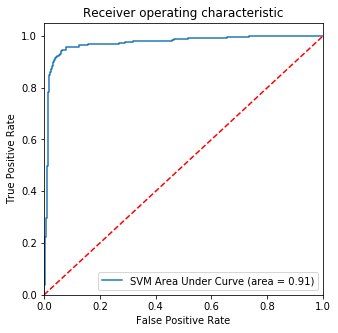

In [0]:
# Produce a ROC curve of this optimized model
matplotlib.rcParams['figure.figsize'] = (5.0, 5.0)
svm_roc_auc = mt.roc_auc_score(y_p1_test, svm_clf.predict(X_p1_test_scaled))
fpr, tpr, thresholds = mt.roc_curve(y_p1_test, svm_clf.predict_proba(X_p1_test_scaled)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM Area Under Curve (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('SVM_ROC')
plt.show()

Again the ROC curve shows a strong model with good predictive performance and an AUC of 0.91. 

### Evaluating the SVM Model: 

Some analysis of the Support Vectors was completed in Mini-lab 1. In general, the model's interpretability does not offer the same insight as that gained through logistic regression. 

Looking at the distribution of the output of the SVM decision function on the training data, we can see both the imbalance in the data set and the ability of the function to discern between the two classes (Left of zero being out of class, Right of zero being in class). This appears to be as close as we can come to visualizing the Support Vectors. We can do the same on the test data. 

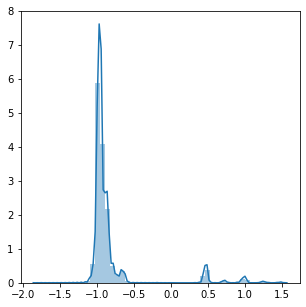

In [0]:
sns.distplot(svm_clf.decision_function(X_p1_train_scaled))

### Random Forest Model

As a third model for comparison, we can attempt to run a classifier using the Random Forest algorithm. As we did in the mini-lab, we begin with a baseline model and then attempt to improve our results by tweaking with a GridSearch to identify ideal parameters. We'll use the same Train/Test data from above. 

Note that it is not necessary to use the scaled data here, so we'll use the original Train / Test split in its untransformed state. 

In [0]:
from sklearn.ensemble import RandomForestClassifier

# Create a new RF model using the default parameters we used in class. Include probability to enable evaluation later. 
rf_clf = RandomForestClassifier()
# fit using the scaled data set
rf_clf.fit(X_p1_train, y_p1_train)

y_hat_rf = rf_clf.predict(X_p1_test) # get test set predictions using scaled data

# print the accuracy and confusion matrix 
print("accuracy", mt.accuracy_score(y_p1_test,y_hat_rf)) 
print("precision", mt.precision_score(y_p1_test,y_hat_rf))
print("recall", mt.recall_score(y_p1_test,y_hat_rf))
print("confusion matrix\n",mt.confusion_matrix(y_p1_test,y_hat_rf))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy 0.9718844984802432
precision 0.7543859649122807
recall 0.7337883959044369
confusion matrix
 [[4901   70]
 [  78  215]]


Out of the box, this Random Forest Classifier with default parameters appears to perform comparably well to the above models. It has increased precision over our balanced selection with the SVM and sacrificies in recall. Though this increase in true predictive performance of our model is preferred. Let's see if we can build a pipeline to optimize this model for improved results. 

In [0]:
#Create a svc pipeline to evaluate the various parameters
pipe = Pipeline([('classifier' , RandomForestClassifier())])


#Paramgrid for all the solver types and with cost functions adjusted for scaled vars
param_rf_grid = [
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators': (100, 200, 300),
    'classifier__criterion' :  ['gini','entropy'],
    'classifier__max_depth': (30, 20, 15),
    'classifier__min_samples_split' : (2, 4, 6),
    'classifier__min_samples_leaf' : (1, 2, 4, 6),
    'classifier__max_features' :  ['log2','sqrt'],
    'classifier__class_weight' :['balanced']}
]

# Create grid search object using precision as the metric
rf_clf = GridSearchCV(pipe, param_grid = param_rf_grid, cv = 3, verbose=True, n_jobs=-1)

# Fit on data
best_rf_clf = rf_clf.fit(X_p1_train, y_p1_train)

# Calculate the predictions
y_hat_rf = best_rf_clf.predict(X_p1_test)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 41.5min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed: 43.3min finished


#### Evaluating the Random Forest Classification Model

In [0]:
print("accuracy", mt.accuracy_score(y_p1_test,y_hat_rf)) 
print("precision", mt.precision_score(y_p1_test,y_hat_rf))
print("recall", mt.recall_score(y_p1_test,y_hat_rf))
print("confusion matrix\n",mt.confusion_matrix(y_p1_test,y_hat_rf))

accuracy 0.9743541033434651
precision 0.7365269461077845
recall 0.8395904436860068
confusion matrix
 [[4883   88]
 [  47  246]]


The improvement here is impressive. We've regained the performance in both precision and recall and have obtained a model that is comparable to the balanced performance of the SVM classifier above. Additionally, the time to train this model was significantly faster than the SVM model and we anticipate the predictive performance to also perform much more rapidly when deployed. We will discuss this further later in the paper. 

In [0]:
best_rf_clf.best_estimator_

Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                        criterion='entropy', max_depth=30,
                                        max_features='log2',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=6,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

#### Plotting the Error of the Random Forest Model

In addition to the above ROC visualizations, confusion matrices, and performance metrics, we sought additional visualizations to help understand how our model was performing. The below plots demonstrate some of these efforts and the insight that can be gained about how our model is performing. 

In [0]:
!pip install forestci
!pip install duecredit

     |████████████████████████████████| 163kB 13.5MB/s 
     |████████████████████████████████| 71kB 4.6MB/s 
     |████████████████████████████████| 163kB 28.1MB/s 
  Created wheel for duecredit: filename=duecredit-0.7.0-cp36-none-any.whl size=74556 sha256=879b8a7db202793391d204330384cd1ac23a92a7af8eb6d422c91efa74e4f923
  Stored in directory: /root/.cache/pip/wheels/50/00/9b/4d562fc3dbd184fa68ffc9dfdbc57b5c83e9bcfd8cf4b6a042
Successfully built duecredit


In [0]:
import forestci as fci

/usr/local/lib/python3.6/dist-packages/forestci/calibration.py:86: RuntimeWarning: overflow encountered in exp
  g_eta_raw = np.exp(np.dot(XX, eta)) * mask
/usr/local/lib/python3.6/dist-packages/forestci/calibration.py:86: RuntimeWarning: overflow encountered in exp
  g_eta_raw = np.exp(np.dot(XX, eta)) * mask
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


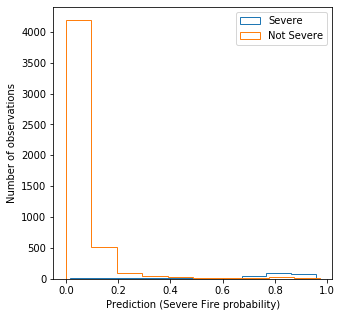

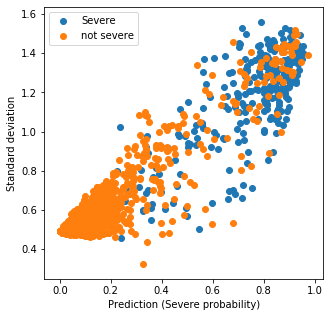

In [0]:
# Create a new RF model using the default parameters we used in class. Include probability to enable evaluation later. 
rf_clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                        criterion='gini', max_depth=20,
                                        max_features='log2',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=200, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False)
# fit using the scaled data set
fit = rf_clf.fit(X_p1_train, y_p1_train)

# Calculate the predictions
y_hat_rf = fit.predict_proba(X_p1_test)
idx_severe = np.where(y_p1_test == 1)[0]
idx_not_severe = np.where(y_p1_test == 0)[0]

# Histogram predictions without error bars:
fig, ax = plt.subplots(1)
ax.hist(y_hat_rf[idx_severe, 1], histtype='step', label='Severe')
ax.hist(y_hat_rf[idx_not_severe, 1], histtype='step', label='Not Severe')
ax.set_xlabel('Prediction (Severe Fire probability)')
ax.set_ylabel('Number of observations')
plt.legend()

# Calculate the variance
severe_V_IJ_unbiased = fci.random_forest_error(fit, X_p1_train, X_p1_test)

# Plot forest prediction for emails and standard deviation for estimates
# Blue points are spam emails; Green points are non-spam emails
fig, ax = plt.subplots(1)
ax.scatter(y_hat_rf[idx_severe, 1],
           np.sqrt(severe_V_IJ_unbiased[idx_severe]),
           label='Severe')

ax.scatter(y_hat_rf[idx_not_severe, 1],
           np.sqrt(severe_V_IJ_unbiased[idx_not_severe]),
           label='not severe')

ax.set_xlabel('Prediction (Severe probability)')
ax.set_ylabel('Standard deviation')
plt.legend()
plt.show()

In the first plot above, we can see the probability distribution of the observations in the predictions we are making. We can see the severe imbalance in the data set and that we are making some high probability predictions for the severe fire. We are also making some low probability predictions. 

This is further visible in the second plot, where we can see that while we are able to handle the primary clusters of severe vs. non-severe, there is still some significant overlap in our model where we predict with some high probability that a fire is incorrectly classified as severe. The good news is that it does not appear to be the majority and we've taken a significant step towards making correct predictions. 

Reference: http://contrib.scikit-learn.org/forest-confidence-interval/auto_examples/plot_spam.html#sphx-glr-auto-examples-plot-spam-py

# Problem 2: Linear Regression Modeling and Analysis

The below analysis attempts to build regression models to predict the value of `total_incident_duration` as we describe in our problem description above. Similar to the classification problems above and work flow from the Mini-lab, we fit an initial model and then attempt a variety of techniques to optimize the performance by changing both the technique used within the model and the parameters passed to individual models. 

We also explore the use of a Random Forest Regressor, which is available via ScikitLearn, but is a new technique (to the team) that has the potential to be more robust to outliers that may be present in our data than other parametric based techniques. 

#### Model 1: Linear Regression

As a baseline, we started by building a straightforward multiple linear regression model. As with any problem, building a strong model requires extensive exploratory data analysis, understanding of the relationship between features, the distribution of features, and the domain expertise related to their underlying meaning. 

While we reference this as our "baseline" model, we actually spent extensive time exploring the features and identifying what attributes were key contributors to the predicted value and transforming some of the categorical variables into smaller binary groups along lines that made sense. 



#### Expanded Feature Engineering

In addition to the feature engineering listed above in the data preparation discussion, we subsequently grouped the following features in for use in the model. Much of this was completed through direct evaluation of the features and trial and error on the training data to understand their utility. 

Due to the extensive modifications, we determined it was best to recreate the data frame from that described above. We stick to the same principles of shuffled distribution. 

In [0]:
# Start with the clean original data frame. 
final_df = pd.read_pickle('final_df.pkl')
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)

In [0]:
# AES presence update
final_df.loc[final_df['aes_presence_desc'] == '1 - Present', 'aes_presence_desc'] = 1
final_df.loc[final_df['aes_presence_desc'] != 1, 'aes_presence_desc'] = 0

# Smoke Detector presence update
final_df.loc[final_df['detector_presence_desc'] == '1 - Present', 'detector_presence_desc'] = 1
final_df.loc[final_df['detector_presence_desc'] != 1, 'detector_presence_desc'] = 0

# Standpipe presence update
final_df.loc[final_df['standpipe_sys_present_flag'] == '1', 'standpipe_sys_present_flag'] = 1
final_df.loc[final_df['standpipe_sys_present_flag'] != 1, 'standpipe_sys_present_flag'] = 0

final_df.dropna(inplace = True)

In [0]:
# Split the alarm code off the front of the description
new = final_df["highest_level_desc"].str.split(" ", n = 1, expand = True) 

# Convert to integer
new[0] = new[0].astype('int32')

# Map the classifications according to alarm code
desc = {2:1, 22:1, 3:1, 33:1, 4:1, 44:1, 5:1, 55:1, 0:0, 1:0, 11:0, 7:1, 75:1,} 
final_df['FireLevel'] = [desc[item] for item in new[0]] 

In [0]:
# PROPERTY TYPE ENCODE

final_df['multifamily'] = 0
final_df[final_df['property_use_desc'] == '429 - Multifamily_dwelling']['multifamily'] = 1

final_df['1_2_family'] = 0
final_df[final_df['property_use_desc'] == '429 - Multifamily_dwelling']['multifamily'] = 1

final_df['residential_street'] = 0
final_df[final_df['property_use_desc'] == '962 - Residential street, road or residential driveway']['residential_street'] = 1

final_df['other_street'] = 0
final_df[final_df['property_use_desc'] == '960 - Street, other']['other_street'] = 1

final_df['commercial_street'] = 0
final_df[final_df['property_use_desc'] == '963 - Street or road in commercial area']['commercial_street'] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [0]:
# BOROUGH ENCODE

final_df['manhattan'] = 0
final_df[final_df['borough_desc'] == '1 - Manhattan']['manhattan'] = 1

final_df['bronx'] = 0
final_df[final_df['borough_desc'] == '2 - Bronx']['bronx'] = 1

final_df['staten_island'] = 0
final_df[final_df['borough_desc'] == '3 - Staten Island']['staten_island'] = 1

final_df['brooklyn'] = 0
final_df[final_df['borough_desc'] == '4 - Brooklyn']['brooklyn'] = 1

final_df['queens'] = 0
final_df[final_df['incident_type_desc'] == '5 - Queens']['queens'] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [0]:
# FIRE TYPE ENCODE

final_df['cooking_fire'] = 0
final_df[final_df['incident_type_desc'] == '113 - Cooking fire, confined to container']['cooking_fire'] = 1

final_df['trash_fire'] = 0
final_df[final_df['incident_type_desc'] == '151 - Outside rubbish, trash or waste fire']['trash_fire'] = 1

final_df['building_fire'] = 0
final_df[final_df['incident_type_desc'] == '111 - Building fire']['residential_street'] = 1

final_df['fuel_fire_contained'] = 0
final_df[final_df['incident_type_desc'] == '116 - Fuel burner/boiler malfunction, fire confined']['fuel_fire_contained'] = 1

final_df['trash_fire_contained'] = 0
final_df[final_df['incident_type_desc'] == '118 - Trash or rubbish fire, contained']['trash_fire_contained'] = 1

final_df['vehicle_fire'] = 0
final_df[final_df['incident_type_desc'] == '131 - Passenger vehicle fire']['vehicle_fire'] = 1         

final_df['structure_fire'] = 0
final_df[final_df['incident_type_desc'] == '112 - Fires in structure other than in a building']['structure'] = 1      

final_df['other_fire'] = 0
final_df[final_df['incident_type_desc'] == '100 - Fire, other']['structure'] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [0]:
# ACTION ENCODE

final_df['extinguish'] = 0
final_df[final_df['action_taken1_desc'] == '11 - Extinguishment by fire service personnel']['extinguish'] = 1

final_df['search'] = 0
final_df[final_df['action_taken1_desc'] == '21 - Search']['search'] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Problem 2: Drops

This trial and error effort actually drastically reduced the number of features that appeared to provide value to the model. The below list of features was removed / kept as shown. 

In [0]:
# SELECTING COLUMNS BY TRIAL AND ERROR


# Columns not used:
#     , 'other_street'
#     , 'commercial_street'
#     , 'detector_presence_desc'
#     , 'trash_fire'
#     , 'trash_fire_contained'
#     , 'other_fire'
#     , 'search'
#     , 'extinguish'
#     , '1_2_family'
#     , 'residential_street'
#     , 'fuel_fire_contained'
#     , 'vehicle_fire'
#     , 'structure_fire'
#     , 'manhattan'
#     , 'bronx'
#     , 'staten_island'
#     , 'brooklyn'
#     , 'queens' 
#       'multifamily'
#     , 'cooking_fire'
#     , 'building_fire'
#     , 'SNOW'
#     , 'PRCP'
#     , 'SNWD'
#     , 'Distance_To_Nearest_Station'
#     , 'FireLevel'
#     , 'units_mo'
#     , 'fire_aes'
#     , 'response_time'
#       'aes_presence_desc'

final_df['fire_aes'] = final_df['FireLevel'] * final_df['aes_presence_desc']
final_df['units_mo'] = final_df['units_onscene'] * final_df['incident_month']
final_df['resp_fire'] = final_df['response_time'] * final_df['FireLevel']


keep_cols = [
     'response_time'
    , 'resp_fire'
    , 'standpipe_sys_present_flag'
    , 'units_onscene'
    , 'LONG'
    , 'LAT'
]

#### Removal of outliers: 

Events with a `total_incident_duration` of greater than 100,000 seconds are more than 27 hours long. These events are outliers within the data set and given the sensitivity of the multiple linear regression technique -- because it is mean-based -- to outliers, we made a determination to exclude these values from our data set. 

In [0]:
lin_df = final_df[final_df['total_incident_duration'] <= 100000]
lin_df['target'] = final_df['total_incident_duration']

X = lin_df[keep_cols]
y = lin_df['target']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Train / Test Split

As we wrote above, the stratification is not as much of a concern here because we have valid values for `total_incident_duration` for the majority of our records. We are able to impute those that we are missing. 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#### Model Fit: 

Let's create the lm object and attempt to fit the model. 

In [0]:
##Fit the model and calculate predictions
lm = LinearRegression()
lm.fit(X_train,y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
yhat = lm.predict(X_test)


Looking at the results plot, we can see that we generally do a decent job of predicting the values when compared to the test set. 

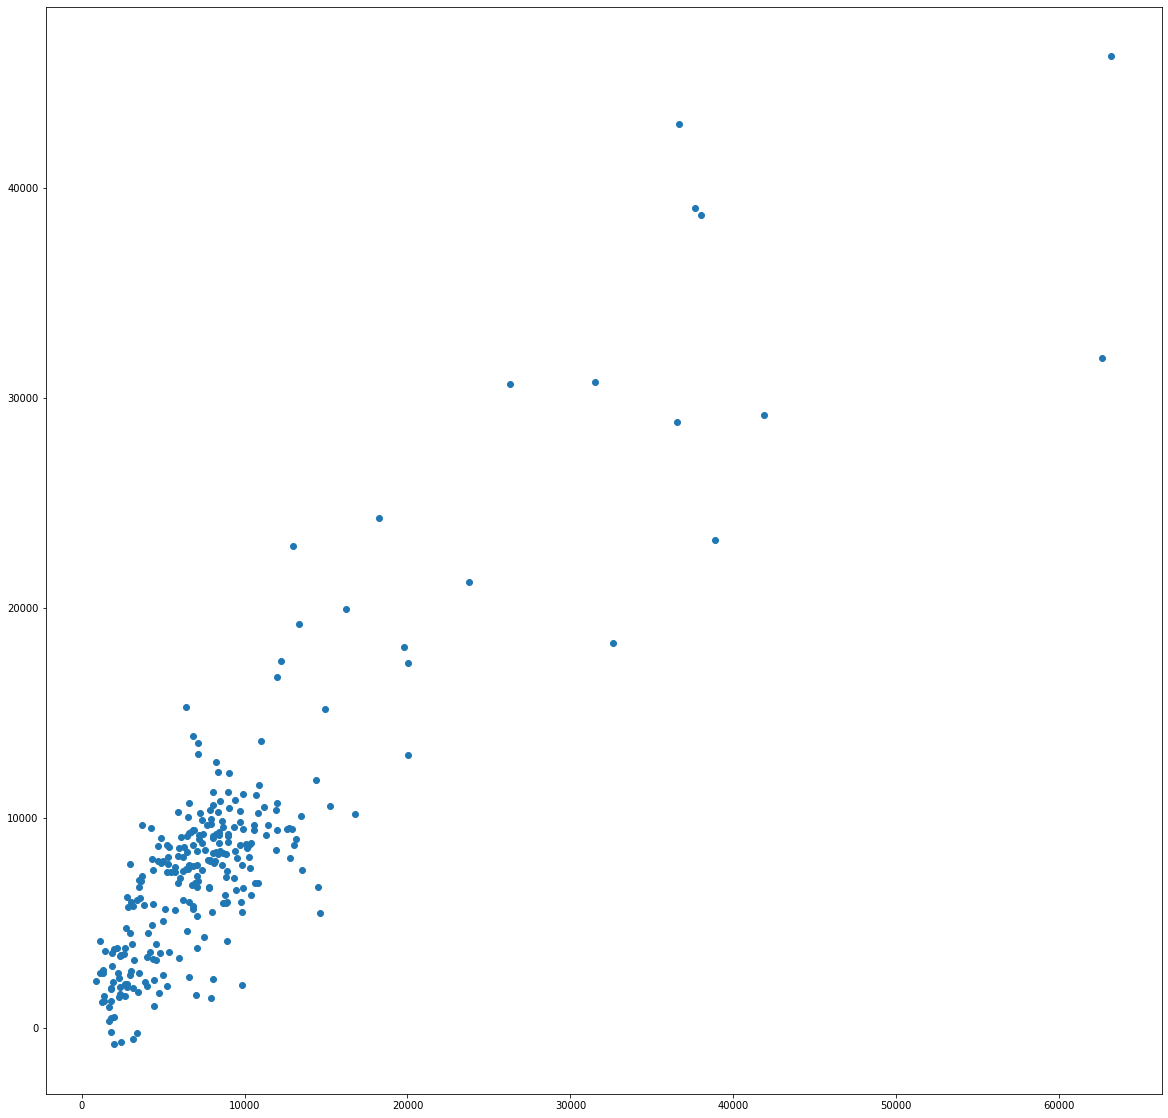

In [0]:
plt.scatter(y_test, yhat)

Residuals for the model appear to be normally distributed and the residuals plot demonstrates a relatively random cloud centered around zero indicating that we have met the linear regression assumptions and can rely on the inferences drawn from this model. 

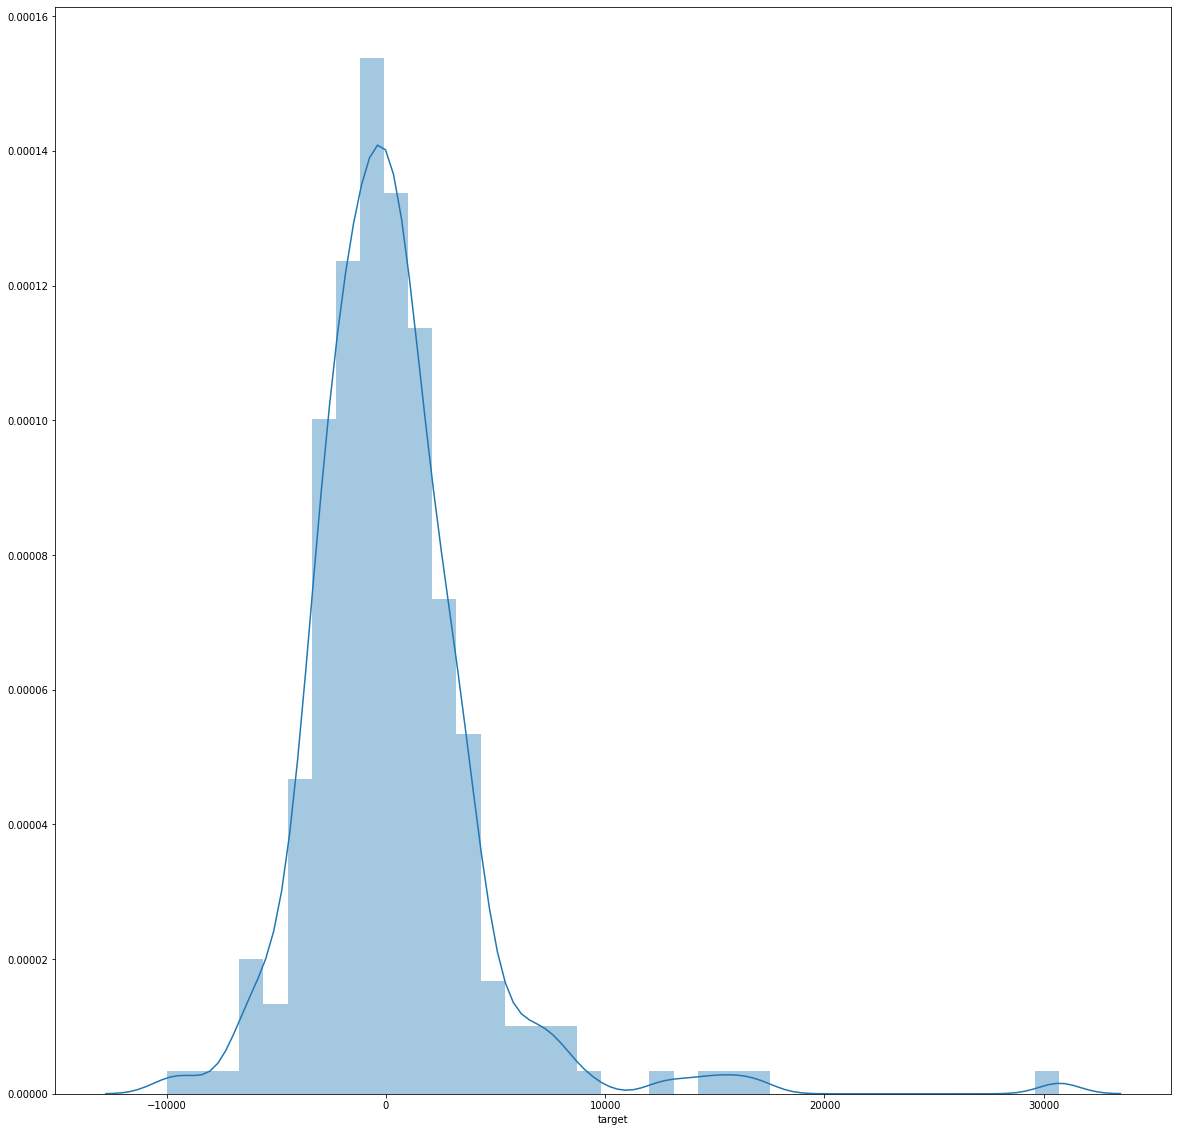

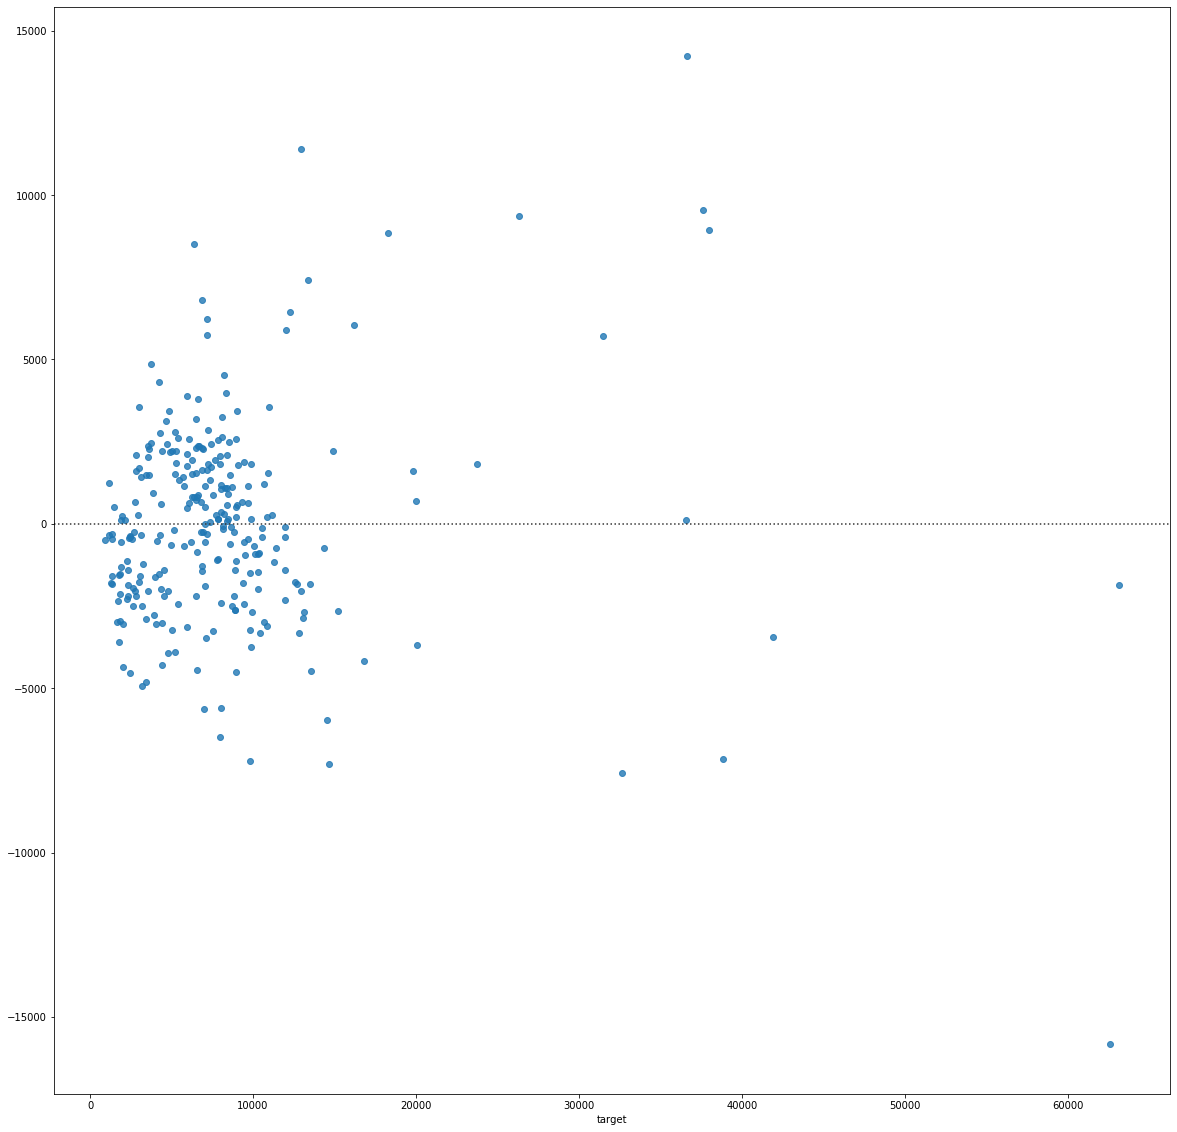

In [0]:
sns.distplot(y_test - yhat)
plt.show()
sns.residplot(y_test, yhat)
plt.show()

#### Evaluating Fit:

Looking at the R^2 value of the model both in the train and the test, we can see that we have reasonably fit the data. These values will give us a baseline to compare to as we attempt to fit additional models. 

In [0]:
SS_Residual = sum((y_test-yhat)**2)
SS_Total = sum((y_test-np.mean(y))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)- X.shape[1]-1)
print (r_squared)
print(adjusted_r_squared)

0.7635228084931186
0.7624733535012241


#### Model 2: Lasso Regression

The LASSO regression model incorporates both feature selection and model optimization techniques. We give it back a more complete subset of features and run the model to see how it produces outcomes. 

In [0]:
keep_cols = [
      'aes_presence_desc'
    , 'response_time'
    , 'resp_fire'
    , 'standpipe_sys_present_flag'
    , 'units_onscene'
    , 'LONG'
    , 'LAT'
    , 'other_street'
    , 'commercial_street'
    , 'detector_presence_desc'
    , 'trash_fire'
    , 'trash_fire_contained'
    , 'other_fire'
    , 'search'
    , 'extinguish'
    , '1_2_family'
    , 'residential_street'
    , 'fuel_fire_contained'
    , 'vehicle_fire'
    , 'structure_fire'
    , 'manhattan'
    , 'bronx'
    , 'staten_island'
    , 'brooklyn'
    , 'queens' 
    ,  'multifamily'
    , 'cooking_fire'
    , 'building_fire'
    , 'SNOW'
    , 'PRCP'
    , 'SNWD'
    , 'Distance_To_Nearest_Station'
    , 'FireLevel'
    , 'units_mo'
    , 'fire_aes'
]


lin_df = final_df[final_df['total_incident_duration'] <= 100000]
lin_df['target'] = final_df['total_incident_duration']

X = lin_df[keep_cols]
y = lin_df['target']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [0]:
lasso = Lasso()
parameters = {'alpha':[1e-15, 1e-10, 1e-8, 1e-8, 1e-4, 1e-3, 1e-2, 1,5, 10, 20]}

lasso_regressor = GridSearchCV(lasso, parameters, scoring = 'neg_mean_squared_error', cv = 3)

lasso_regressor.fit(X_train,y_train)

print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

yhat = lasso_regressor.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6270803714.7932005, tolerance: 4368185.597237984
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7057455048.222718, tolerance: 4924300.695884967
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6430451652.853975, tolerance: 4485041.588264001
  positive)


{'alpha': 20}
-20313038.32004594


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
SS_Residual = sum((y_test-yhat)**2)
SS_Total = sum((y_test-np.mean(y))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)- X.shape[1]-1)
print ('R-squared value for LASSO: ', r_squared)
print('Adjusted R-squared value for LASSO: ', adjusted_r_squared)

R-squared value for LASSO:  0.7582662076858316
Adjusted R-squared value for LASSO:  0.7518711338150864


As we can see, the R-squared values for this model are nearly identical to our baseline model. This model would obviously take less time to achieve a similar result to our trial and error method and might serve as an easier foundation. 

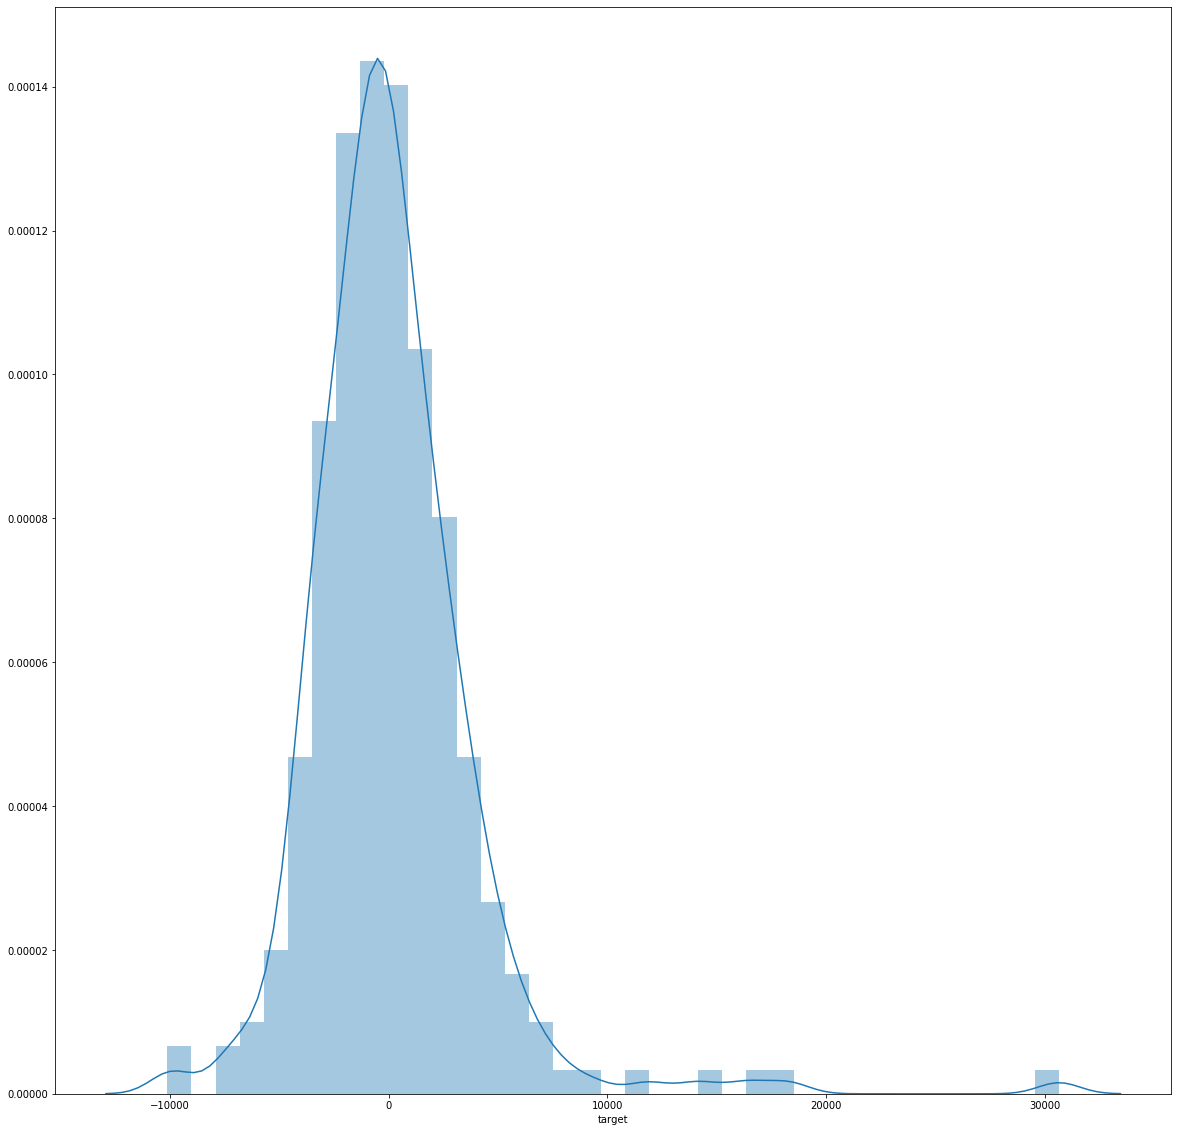

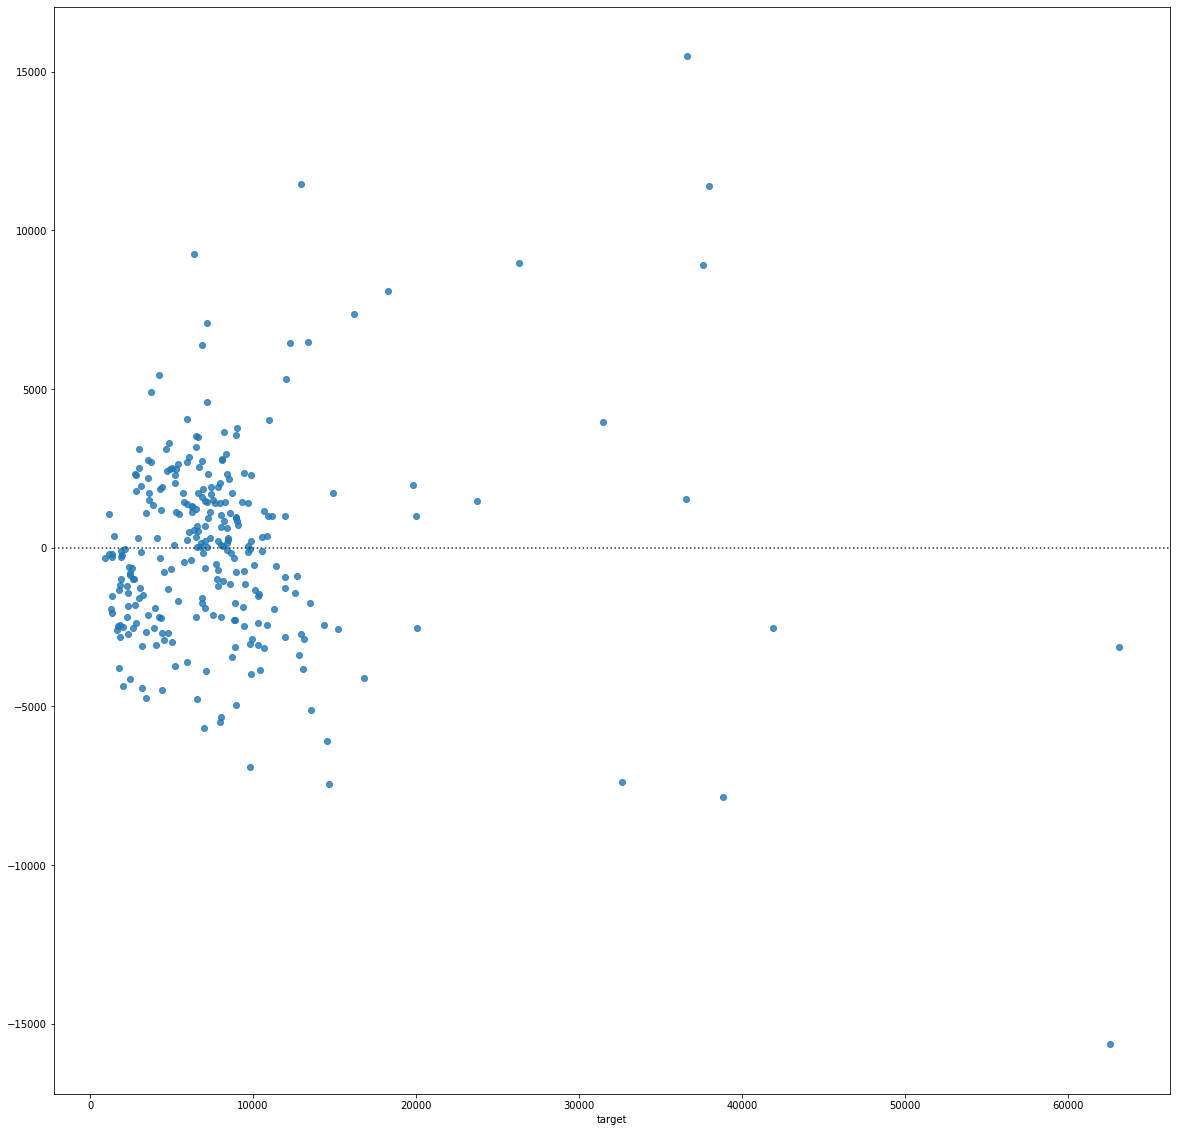

In [0]:
sns.distplot(y_test - yhat)
plt.show()
sns.residplot(y_test, yhat)
plt.show()

#### Model 3: Random Forest Regressor

As an experiment, we wanted to see how our data performs in a Random Forest Regressor. This applies the random forest technique used in classification to determine continuous values as a regression response. Although linear regression is itself a high-performance technique once fit, the random forest regressor can also be expected to perform quickly on new data and may be worth trying here. It also may have the ability to capture subtlety that a linear regression model cannot. 

In [0]:
from sklearn.ensemble import RandomForestRegressor


In [0]:
#Fit the random forest regressor with 1000 trees. 
rfr = RandomForestRegressor(n_estimators=1000)
model2 = rfr.fit(X_train, y_train)
yhat_rfr = model2.predict(X_test)

In [0]:
#Look at the R-square for both train and test. 
print("RFR Train R2: ", model2.score(X_train, y_train))
print("RFR R2: ", model2.score(X_test, y_test))

RFR Train R2:  0.9553084295931068
RFR R2:  0.7852005104728406


While we always expect the data to be a better fit for the training data, here we can see the potential downside of a Random Forest Regressor. It might have a tendency to overfit the data and we can see that the training data performs significantly worse against the model. Still, this model is better than our other previous models even on the training data. 

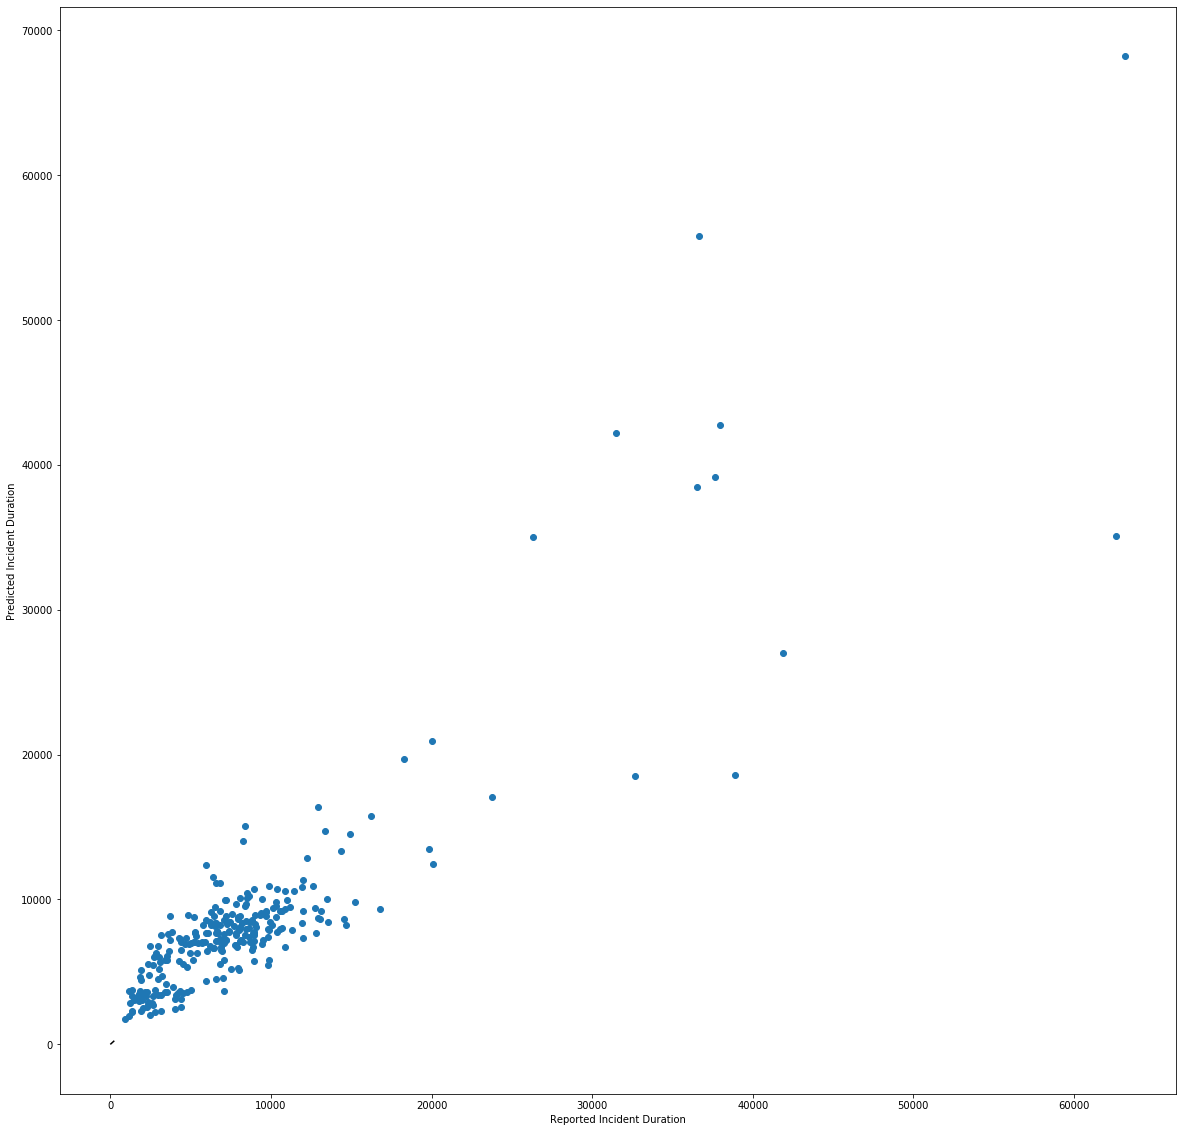

/usr/local/lib/python3.6/dist-packages/forestci/calibration.py:86: RuntimeWarning: overflow encountered in exp
  g_eta_raw = np.exp(np.dot(XX, eta)) * mask
/usr/local/lib/python3.6/dist-packages/forestci/calibration.py:101: RuntimeWarning: overflow encountered in exp
  g_eta_raw = np.exp(np.dot(XX, eta_hat)) * mask
/usr/local/lib/python3.6/dist-packages/forestci/calibration.py:102: RuntimeWarning: invalid value encountered in true_divide
  g_eta_main = g_eta_raw / sum(g_eta_raw)


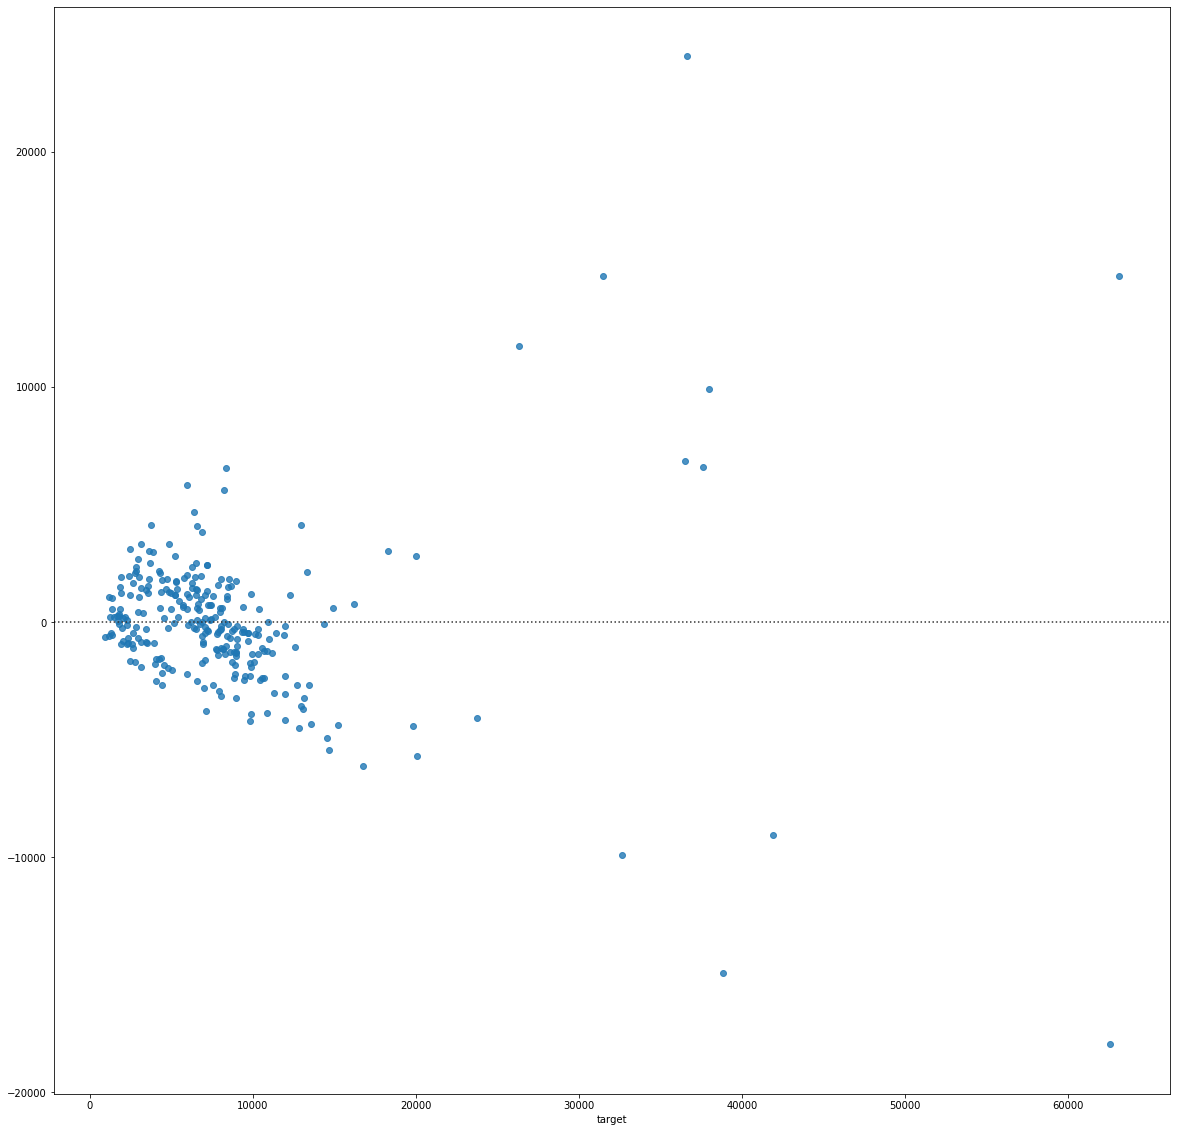

In [0]:
# Plot predicted MPG without error bars
plt.scatter(y_test, yhat_rfr)
plt.plot([0, 250], [0, 250], 'k--')
plt.xlabel('Reported Incident Duration')
plt.ylabel('Predicted Incident Duration')
plt.show()

# Calculate the variance:
duration_V_IJ_unbiased = fci.random_forest_error(model2, X_train,X_test)

sns.residplot(y_test, yhat_rfr)
plt.show()

##### Assumptions don't look well met, let's try the SQRT Transform

Above the assumptions of linear regressive models (although not required to be met here) do not appear to be met. That said, we can still attempt to understand the true relationship in the data to aid in our interpretation. The conical and expanding shape of the residuals would seem to indicate that there is some relationship and experience tells us that a sqrt transform might help. 

In [0]:
rfr = RandomForestRegressor(n_estimators=1000)
model2 = rfr.fit(X_train, np.sqrt(y_train))
yhat_rfr = model2.predict(X_test)

In [0]:
print("RFR Train R2: ", model2.score(X_train, np.sqrt(y_train)))
print("RFR R2: ", model2.score(X_test, np.sqrt(y_test)))

RFR Train R2:  0.9521925397980341
RFR R2:  0.7784728791381001


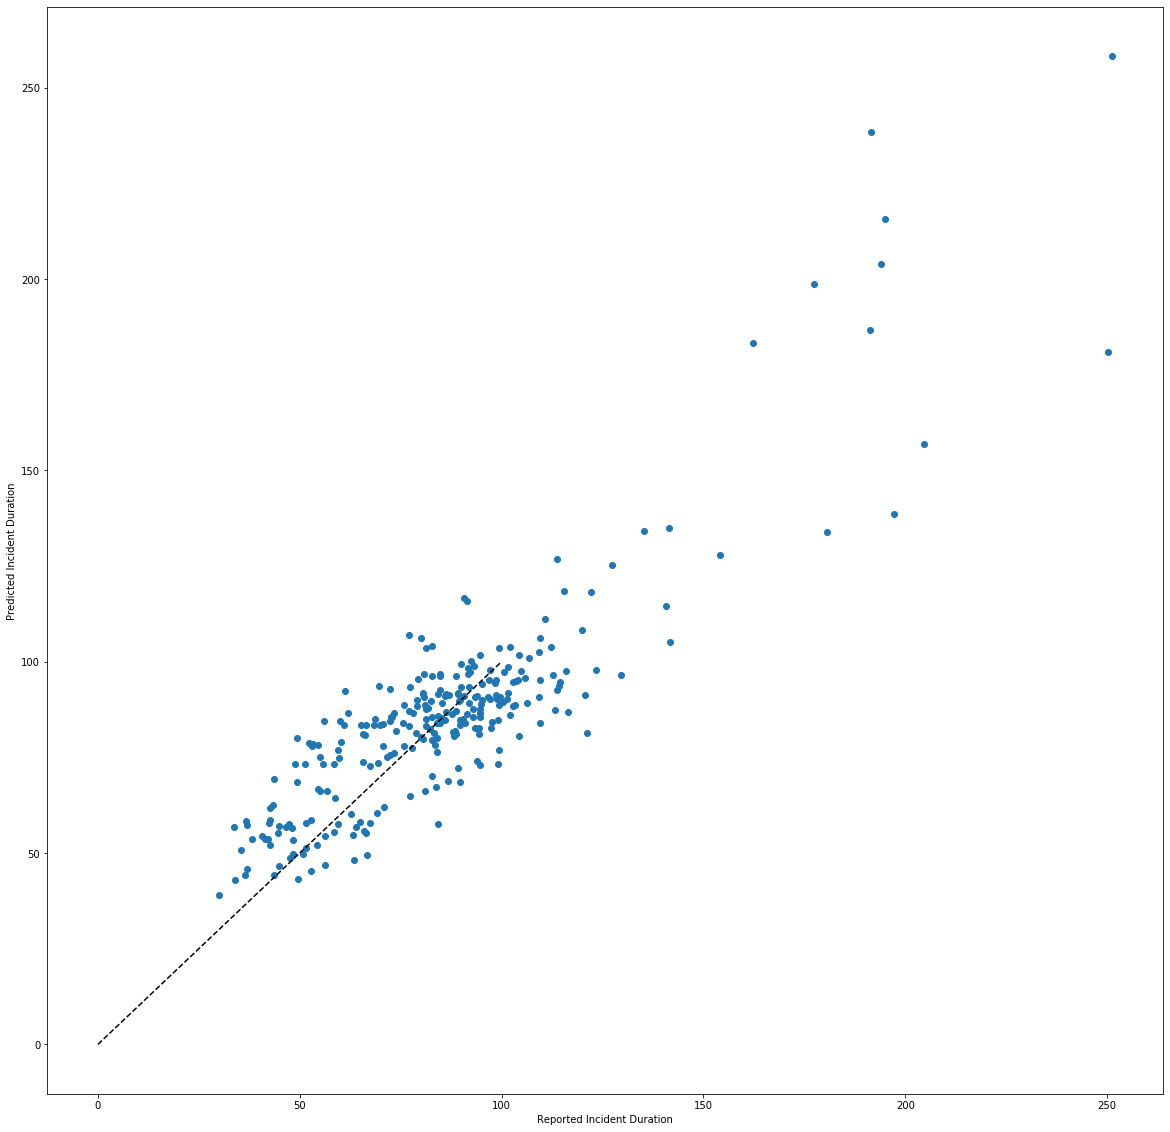

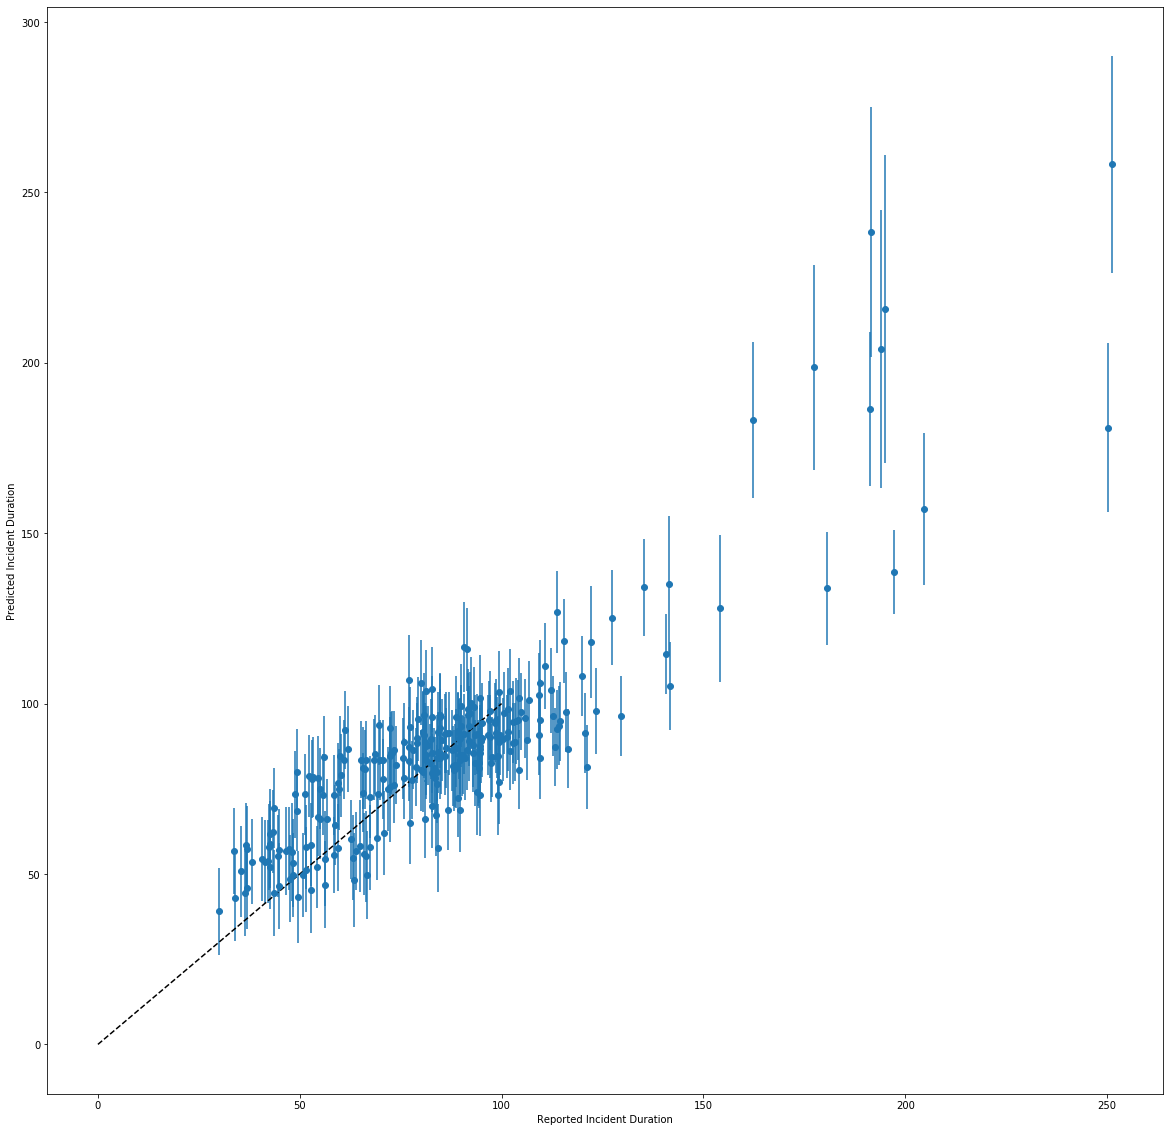

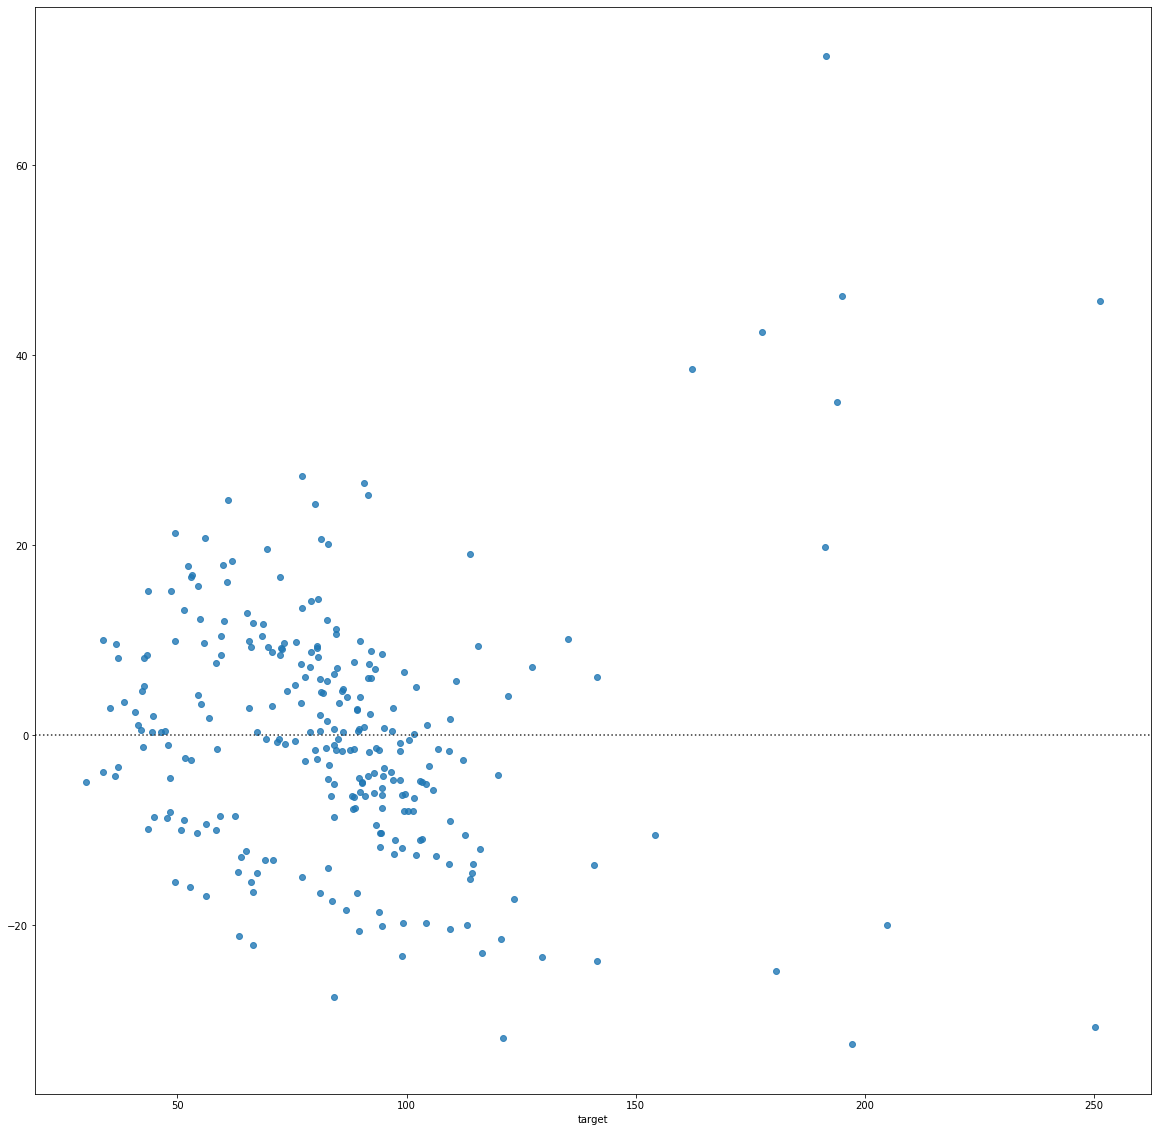

In [0]:
# Plot without error bars
plt.scatter(np.sqrt(y_test), yhat_rfr)
plt.plot([0, 100], [0, 100], 'k--')
plt.xlabel('Reported Incident Duration')
plt.ylabel('Predicted Incident Duration')
plt.show()

# Calculate the variance:
duration_V_IJ_unbiased = fci.random_forest_error(model2, X_train,X_test)

# Plot error bars for predicted values using unbiased variance
plt.errorbar(np.sqrt(y_test), yhat_rfr, yerr=np.sqrt(duration_V_IJ_unbiased), fmt='o')
plt.plot([0, 100], [0, 100], 'k--')
plt.xlabel('Reported Incident Duration')
plt.ylabel('Predicted Incident Duration')
plt.show()

sns.residplot(np.sqrt(y_test), yhat_rfr)
plt.show()

These plots look much better. The predicted values vs. the actual values lie along a nice linear relationship with reasonable error plots. The residuals are normal and random in appearance. The R^2 appears to perform at least as well as with the untransformed data, but we can rely on the interpretation here because we have met the statistical assumptions. 

In looking at the error bars of the predicted values, we can see that the error is roughly constant across the data set and the error bars contain the actual value for the majority of the data, implying that we can have good confidence in our predictions. 

The relationship in our model appears to be one where the dependent variable is the sqrt of the linear equation. We should be able to back transform if we want to interpret any specific outcome simply by squaring the dependent variable, but interpretation of the coefficients (if needed) would need to be done on the sqrt scale. 

Reference: http://contrib.scikit-learn.org/forest-confidence-interval/auto_examples/plot_spam.html

#### Exploring the Forest: 

Below we attempt to explore how the Random Forest Regressor is executing the splits that it has pursued. In looking at the 5th estimator (tree in the forest) we can see that the number of Units Onscene is responsible for the primary splits at the beginning of the tree. Then location based features such as LAT/LONG come into play. 

This visualization is only one of the trees in the model, but does offer insight into exploring the feature importance. 

In [0]:

estimator = rfr.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_train.columns,
                class_names = "target",
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

#### Model 4: Gradient Boosting Regressor

Another potential model is a Gradient Boosting Regressor. While we are not extensively familiar with Gradient Boosting models, we understand that they are also not subject to the assumptions of linear regression. However, in researching these models, we understand that they seek to explain and optimize the patterns found in residuals after fitting a model. They then take this insight and train a new model to minimize the error described in the residuals for a number of iterations until fit. 

We attempted a number of models selected by Grid Search, but the process was too lengthy to submit for this notebook. One of the best performing models is below. 

Reference: https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d

In [0]:
from sklearn.ensemble import GradientBoostingRegressor

#Fit the GBR model
gbr=GradientBoostingRegressor(learning_rate=0.1,loss='lad',max_depth=110,max_features='sqrt',min_samples_leaf=2,min_samples_split=5,n_estimators=200);
gbr.fit(X_train,y_train)
yhat_gbr = gbr.predict(X_test)

In [0]:
#Obtain the R-square value
SS_Residual = sum((y_test-yhat)**2)
SS_Total = sum((y_test-np.mean(y))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)- X.shape[1]-1)
print ('R-squared value for GBR: ', r_squared)
print('Adjusted R-squared value for GBR: ', adjusted_r_squared)

R-squared value for GBR:  0.7582662076858316
Adjusted R-squared value for GBR:  0.7518711338150864


We can see here that the model performs well with an Adjusted R-square near 0.76 which is on-par with our other models. The residuals plot below, though, looks about the same as other plots above. It appears that all of our models are doing a decent job explaining the data and we'll essentially have to look elsewhere for improving the model or base our decision on performance metrics and ease of deployment for whatever environment we are looking to deploy in.  

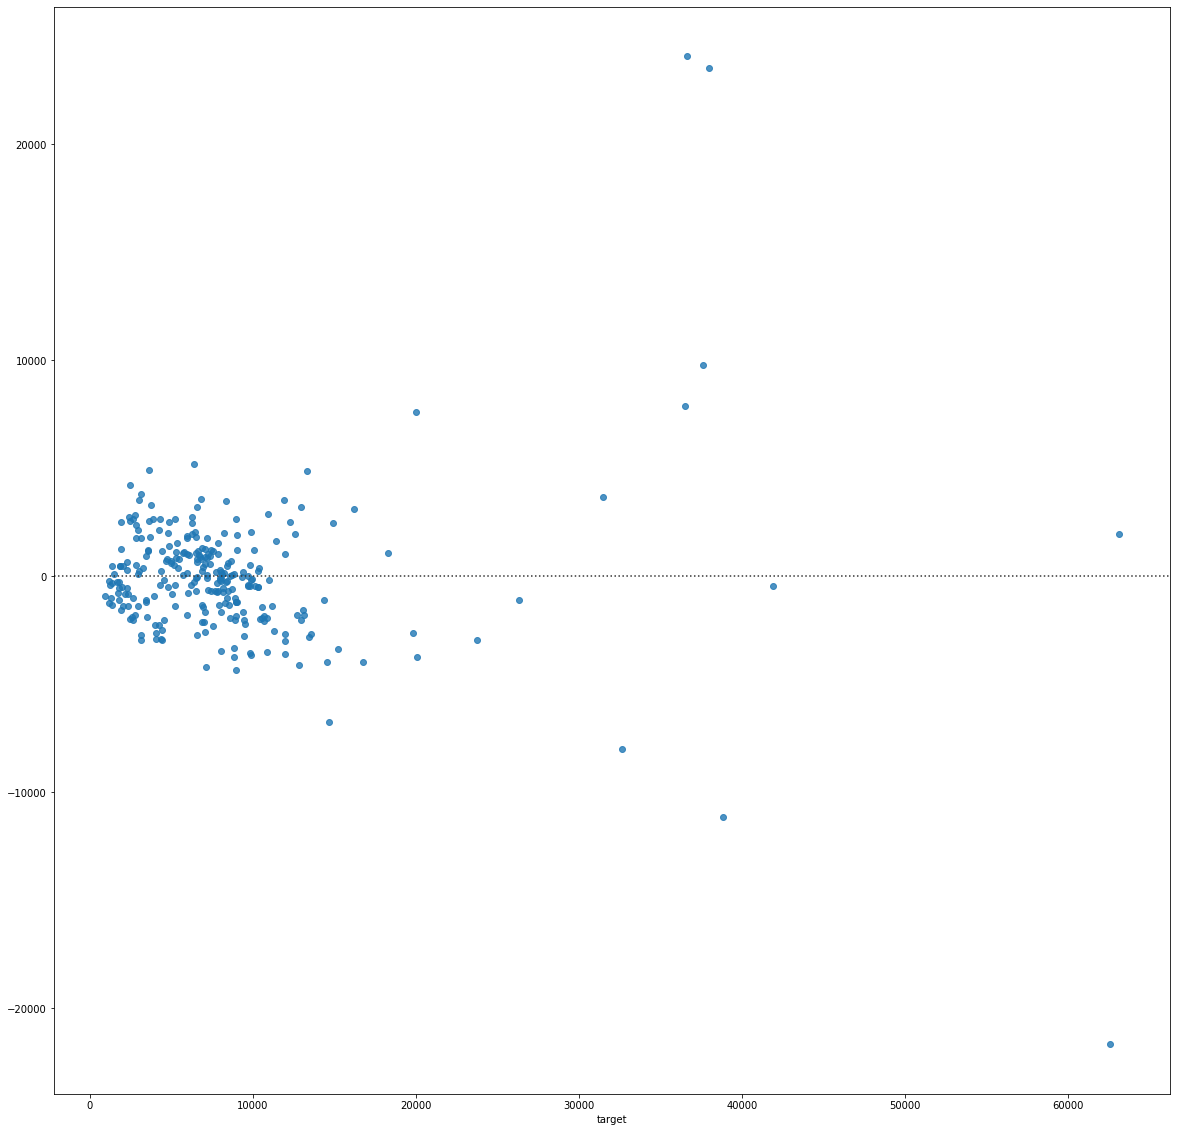

In [0]:

sns.residplot(y_test, yhat_gbr)
plt.show()

1. LONG (0.141503)
2. Distance_To_Nearest_Station (0.141340)
3. LAT (0.141055)
4. units_mo (0.128944)
5. response_time (0.128182)
6. units_onscene (0.101632)
7. resp_fire (0.097577)
8. PRCP (0.056801)
9. detector_presence_desc (0.015096)
10. FireLevel (0.011935)


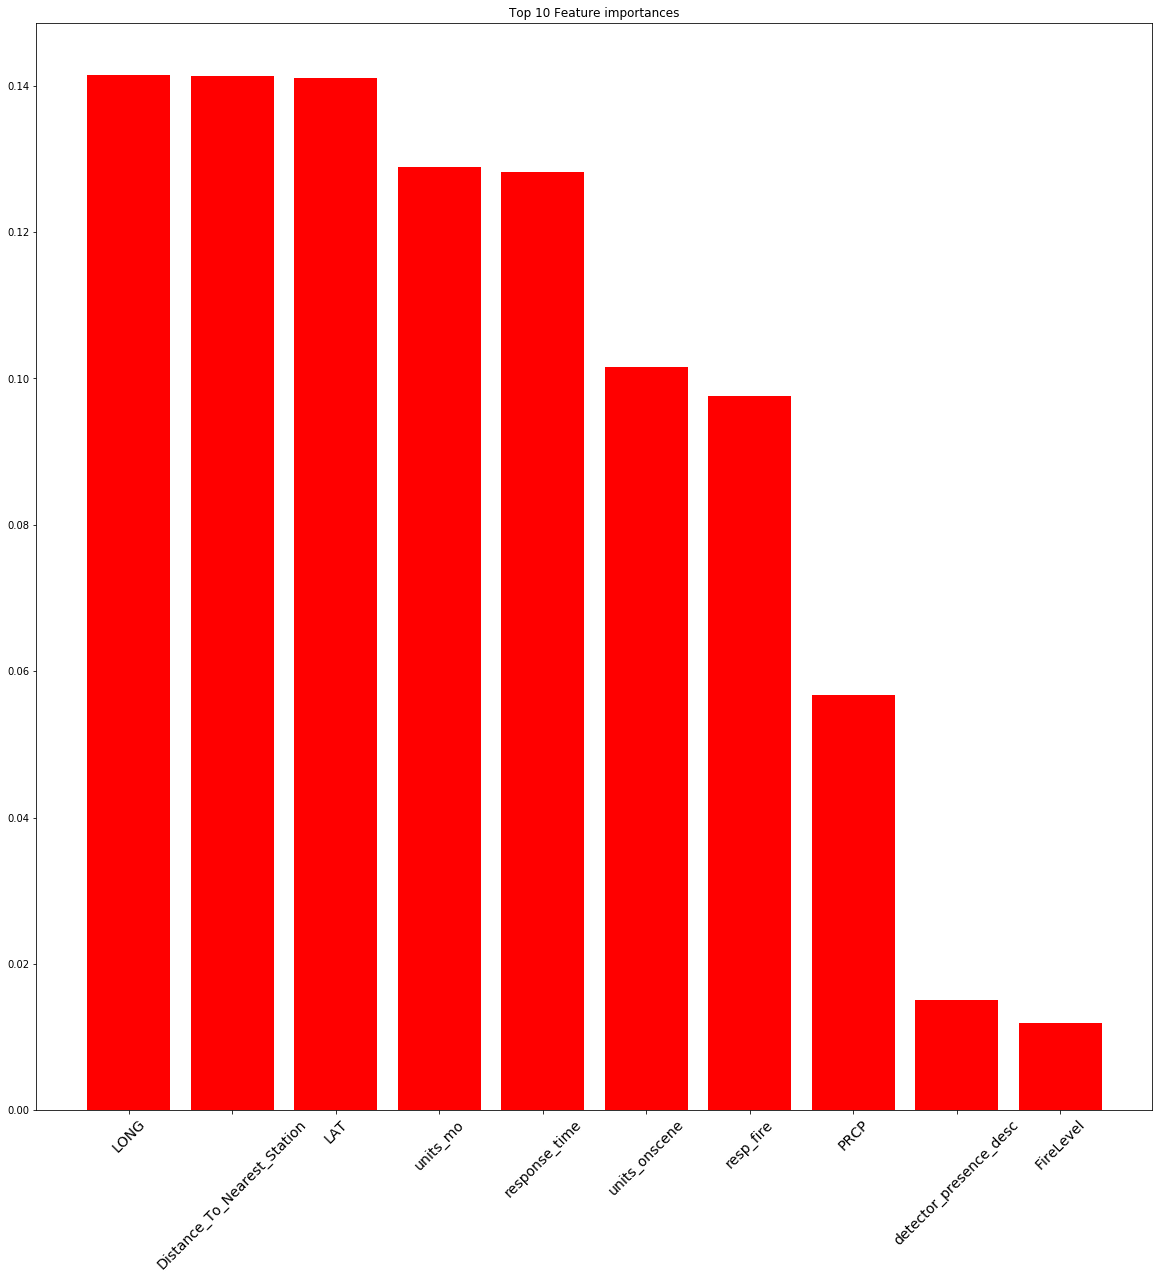

In [0]:
importances = gbr.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(10):
  print("%d. %s (%f)" % (f + 1, X_test.columns[indices[f]], importances[indices[f]]))

import matplotlib.pylab as plt
indices=indices[:10]
plt.figure()
plt.title("Top 10 Feature importances")
plt.bar(range(10), importances[indices], color="r")
plt.xticks(range(10), X_test.columns[indices], fontsize=14, rotation=45)
matplotlib.rcParams['figure.figsize'] = (40.0, 10.0)
plt.show()

#### Feature Importance in the GBR Model: 

Looking at the features of the GBR model, we can see that location (LAT / LONG) and Distance to Nearest Station are among the most important features in determining the total response time. We saw above that specific boroughs (and regions in boroughs) were at more risk of having severe fires. If we explore this further, we'd likely see that these boroughs are at the same level. 

Interestingly, the severity of the fire, fire level, is an important contributor, but is only 10th in importance. Remember that severe fires are uncommon in the data set. 

Finally, the interaction terms of (units * incident month) and (response time * fire level) are among the most important. This indicates that responding to a fire quickly based on its severity can have a significant impact on the overall duration. Also, the (incident month * unit) interaction might mean some seasonal relationship in the incident duration that we have so far been unable to explore, but might be able to with more time. 

## Deployment

### Problem 1 Deployment: 

Any of the models built in Problem 1 could be exported to a pickle object and imported into compatible code. Although our model was designed to support more of an insight-based analytic result rather than a "live-deployment" scenario, it could be hosted on a web server with fire incidents being sent to it for classification as they occur. 

Due to the wide variety of fire events, updating the model on a rapid basis does not likely make sense. The model would need to be re-trained as the dynamics of neighborhood shifts (eg: types of structures dominating a neighborhood), new fire departments are built, and perhaps most importantly as the decision makers leverage the model to implement real change in the environment. This, perhaps, could have the most impact on whether the model persists in being accurate. 

We would recommend a 6 month review of the model's performance and update if required. This could also help the decision makers in capturing trends over time as they evaluate primary contributors to fire severity. 

### Problem 2 Deployment: 

The models in problem 2 can be deployed in much the same way. In this analytic problem, there is a more direct relationship to the need for rapid decision making. If a fire chief seeks to leverage the model to react to multiple fire resources, model performance will be much more of the essence. 

### Additional Data: 

For both models, we have attempted to gather as much additional data as is possible. We considered, but were unable to identify, incorporation of economic data to identify whether there is a correlation between affluence of the neighborhood (or sub neighborhoods) and the timeliness of the fire department's response. Additionally, our precipitation data -- which seems to have a significant impact on the outcome in both models -- is drawn for the entire city. It may be possible to get more location specific precipitation information to help improve the effect of the model if more is done with the geo-reference aspects of the model.

### Model Value: 

Each of these models is primarily designed to provide insight to the decision making teams in the NY Fire Department. The value will ultimately come based on improvement in outcomes for the fire department through decreased use of resources, adjustment of fire officer's schedules to maximize response, etc. As we can see, location plays a key role in the total duration of a fire incident both of the station and the fire itself. This proximity might help to identify under-served areas where additional fire resources could be deployed. 

Additionally, the month in which an incident occurs is regularly a factor in many models and may allow some seasonal adjustment of resource allocation. 

### Exceptional Work: 

The team went to extensive lengths to explore a variety of approaches to this data and the associated models. We explored the ability to extract trees from the random forest models and gain insight into how -- at least a subset -- of the models are deriving the insights and where they are making the splits. 

We also sought to ensure that our inferences are linked to strong statistical assumptions required of these models and therefore meet the ability to make confident assessments of the data and to expand our inference beyond the exact data set. This is demonstrated by exploring the residual plots, predicted vs. actual plots, and other visualizations. 

Finally, we expanded our interest area to models that were not necessarily covered in class to include both the RandomForestRegressor as a predictor of a continuous value rather than class and the Gradient Boosted Regressor in an attempt to gain additional performance. 

### Significant parameters: 

We were able to directly observe improvement in our models based on the number of cross validation runs we made. While generally marginal gains, they were there and we expect that our models more accurately capture the variability in the data as a result. Unfortunately the time to run these iterations and limited computing power available were a limiting factor. 

In the random forest based models, we experimented with the number of trees in each forest (estimators) and found that running models with trees in the thousands did provide some improved performance. The high speed performance of these models made it easy to run a variety of iterations and find the optimal balance and ensure the model did not overfit. 

## Conclusion

We've experimented with a number of models against two different classes of problems. Both problems and the models we developed provide some insight into the contributors to the severity of fires and the ability to predict total incident duration given the set of features.